# import and functions

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import get_window
from numpy.fft import fft
import json
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.signal import hilbert, convolve
import random
import scipy 
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import pickle


##################################

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

##################################

def load_in_replay_data(mouse,old_data_bool):
    
    print('---------------------')
    print('searching for replay data')
    if old_data_bool:
        dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
    else:
        dat_path = ERROR_REPLACE_ME

    pp_path = 'SKIP'
    for file in os.listdir(dat_path):
        if mouse in file:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)
    
    if pp_path == 'SKIP':
        return None,'SKIP'
    replay_data_path = pp_path + r'\analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
    
    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]


            print(replay_data_path)

            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            df_load['chunk'] = [chunk_number]*len(df_load)
            
            df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
            fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
            df_load['first_spike_ephys_time'] = fs_times_ephys_time
            df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
            replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
            replay_events_df.reset_index(drop = True)

    # if mouse == '178_1_7':              
    #     spikes_file = os.path.join(pp_path,'trainingData\\') + mouse + '.txt'
    #     neuron_ids, spike_times= [], []
    #     with open(spikes_file) as f:
    #         for (i, line) in enumerate(f.readlines()):
    #             [neuron_id, spike_time] = line.split(' ', 1)
    #             spike_time = eval(spike_time.split('\n')[0])
    #             neuron_id = eval(neuron_id.split('\t')[0])
    #             spike_times.append(spike_time)
    #             neuron_ids.append(neuron_id)
    #     spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

    #     print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    #     print('---------------------')
    #     return replay_events_df,spikes_df
    # else:
    print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    print('---------------------')
    return replay_events_df, None

##################################

def determine_spectral_power(x, fmin, fmax, fs, window, overlap):
    window_size = int(fs * window)
    step_size = int(fs * (window - overlap))
    
    # Create a Hanning window to reduce spectral leakage
    win_func = get_window("hann", window_size)
    
    delta_spectral_power = []
    timestamps = []
    
    for i in range(0, len(x) - window_size + 1, step_size):
        x_win = x[i:i + window_size] * win_func
        X_win = fft(x_win)
        freqs = np.fft.fftfreq(window_size, d=1/fs)
        
        # One-sided spectrum
        pos_mask = freqs > 0
        freqs = freqs[pos_mask]
        psd = (np.abs(X_win)**2 / (fs * np.sum(win_func**2)))[pos_mask]  # normalized PSD
        
        # Find indices for desired frequency band
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        sp = np.sum(psd[band_mask])
        delta_spectral_power.append(sp)
        
        # Add center timestamp of current window
        timestamps.append((i + window_size / 2) / fs)
    
    return delta_spectral_power,timestamps

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spectral_powers = []
    spectral_timestamps = []
    replay_binned = []
    replay_bin_ts = []
    fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
    cumulative_chunk_time = 0
    for i in range(max(replay_events_df.chunk)):
        chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
        chunk_time = chunk_dat.chunk_time[0]  

        R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
        
        # bin into 1s bins and take replay rate 
        bin_size = 1
        hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        ## add to cumulative chunk time counter 
        cumulative_chunk_time += np.diff(chunk_time)[0]
        
        chunk_delta_spectral_power = np.array(delta_spectral_power)[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]
        chunk_delta_timestamps = delta_timestamps[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]

        # Calculate bin centers
        bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]

        ax[i].plot(chunk_delta_timestamps,convolve_movmean(chunk_delta_spectral_power,30), 'blue')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(var_string,color = 'blue')
        ax[i].set_title(f'{var_string} vs replay rate')
        ax2 = ax[i].twinx()
        ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
        ax2.set_ylabel('replay rate', color = 'red')
        
        # Add shaded regions without repeating labels
        for ind, (start, end) in enumerate(rem_start_ends):
            label = 'rem' if ind == 0 else None
            ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

        for ind, (start, end) in enumerate(nrem_start_ends):
            label = 'nrem' if ind == 0 else None
            ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
            
        ax[i].set_xlim(chunk_time[0], chunk_time[1])


        if i == max(replay_events_df.chunk) -1:
            # Move legend off to the right
            ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
            
        # set the tight layout
        plt.tight_layout()
        
        # pull out the data for other analysis 
        spectral_powers += [chunk_delta_spectral_power]
        spectral_timestamps += [chunk_delta_timestamps]
        replay_binned += [hist]
        replay_bin_ts += [bin_centers]

    return spectral_powers, spectral_timestamps, replay_binned, replay_bin_ts




def phase_randomize(signal):
    n = len(signal)
    # FFT
    fft_vals = np.fft.fft(signal)

    # Preserve magnitude
    mag = np.abs(fft_vals)

    # Random phase, symmetric to ensure real inverse
    random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, n//2 - 1))
    phase = np.ones(n, dtype=complex)
    phase[1:n//2] = random_phases
    phase[-(n//2)+1:] = np.conj(random_phases[::-1])  # Hermitian symmetry

    # New FFT
    new_fft = mag * phase

    # Inverse FFT
    randomized_signal = np.fft.ifft(new_fft).real
    return randomized_signal


def calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=5000):

    chunk_cross_corr_actual = []
    chunk_temporal_shuffle = []
    chunk_phase_shuffle = []
    for i in range(len(spndl_replay_binned)):
        
        
        signal1 = zscore(convolve_movmean(replay_aligned_spndl_spectral_powers[i], smoothing_window))
        signal2 = zscore(convolve_movmean(spndl_replay_binned[i],smoothing_window))
        # cross-correlation
        cross_corr_actual = np.correlate(signal1, signal2, mode='full')

        # Initialize an array to store shuffled cross-correlation values
        temporal_shuffle = []
        phase_shuffle = []
        # Perform shuffling and calculate cross-correlation for each iteration
        for i in range(num_shuffles):
            # Shuffle one of the signals (you can choose which one to shuffle)
            t_shuffled_signal1 = np.random.permutation(signal1)
            # do a phase randomisation shuffle
            p_shuffled_signal1 = phase_randomize(signal1)
            # Calculate the cross-correlation with the shuffled signal
            temporal_shuffle += [list(np.correlate(t_shuffled_signal1, signal2, mode = 'full'))]
            phase_shuffle += [list(np.correlate(p_shuffled_signal1, signal2, mode = 'full'))]
            
        percntl_99_temporal = np.percentile(temporal_shuffle, 99, axis=0)
        percntl_99_phase = np.percentile(phase_shuffle, 99, axis=0)

        time_lags = np.arange(-len(signal1) + 1, len(signal1))
        
        chunk_cross_corr_actual += [list(cross_corr_actual[(time_lags > -300) * (time_lags < 300)])]
        chunk_temporal_shuffle += [list(percntl_99_temporal[(time_lags > -300) * (time_lags < 300)])]
        chunk_phase_shuffle += [list(percntl_99_phase[(time_lags > -300) * (time_lags < 300)])]

            
    return chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle






In [3]:
### spindle filtering!
#compute a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms)

# We computed a smoothed envelope of this signal, the magnitude of the Hilbert transforms with convolving by a Gaussian window (200 ms). 
# Next, we determined two thresholds for spindle detection based on the mean (μ) and standard deviation (σ) of the spindle band envelope during NREM sleep; 
# the upper and lower thresholds were set μ + 2.5 × σ and μ + 1.5 × σ, respectively. Epochs in which the spindle power exceeded the upper threshold for at least one sample 
# and the spindle power exceeded the lower threshold for at least 500 ms were considered spindles. 
# Each epoch where the spindle power exceeded the lower threshold was considered the start and stop of the spindle; the duration of each spindle was based on these values as well. 
# For the reactivation analyses spindles was detected in 13-16 Hz based on the previous finding that fast spindles (13-16 Hz) play a key role for sleep-dependent memory reactivation


def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def determine_spindle_rates(spindle_events,nrem_start_ends):
    total_time = 0
    start_times = []
    for i,nrem_int in enumerate(nrem_start_ends):
        total_time += np.diff(nrem_int)[0]
        for data_dict in spindle_events:
            if data_dict['start_time'] > nrem_int[0] and data_dict['start_time'] < nrem_int[1]:
                start_times.append(data_dict['start_time'])
    if total_time > 0:
        events_per_minute = len(start_times)/(total_time/60)
    else:
        events_per_minute = 0
    return events_per_minute


# plot the spindle rate vs replay rate
def plot_replay_vs_spindle_events(spindle_events,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spin_event_times = [item['start_time'] for item in spindle_events]
    binned_spindle_times = []
    binned_replay_times = []
    bin_centres = []
    fig,ax= plt.subplots(1, max(replay_events_df.chunk),figsize=(15, 3))
    cumulative_chunk_time = 0
    for i in range(max(replay_events_df.chunk)):
        chunk_dat = replay_events_df[replay_events_df.chunk == i+1]
        chunk_dat = chunk_dat.reset_index(drop = True)
        chunk_time = chunk_dat.chunk_time[0]  

        R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
        
        # bin into 1s bins and take replay rate 
        bin_size = 1
        hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        # rebase the spindle times for the chunk timescale
        chunk_spin_event_times = np.array(spin_event_times)[(np.array(spin_event_times) > chunk_time[0])*(np.array(spin_event_times) < chunk_time[1])] - chunk_time[0]
        
        # bin into 1s bins and take spindle rate 
        bin_size = 1
        hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
        
        ## add to cumulative chunk time counter 
        cumulative_chunk_time += np.diff(chunk_time)[0]
        
        # Calculate bin centers
        bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]
        
        ax[i].plot(bin_centers,convolve_movmean(hist2,30), color = 'purple')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel(var_string,color = 'purple')
        ax[i].set_title(f'{var_string} vs replay rate')
        ax2 = ax[i].twinx()
        ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
        ax2.set_ylabel('replay rate', color = 'red')
        
        # Add shaded regions without repeating labels
        for ind, (start, end) in enumerate(rem_start_ends):
            label = 'rem' if ind == 0 else None
            ax[i].axvspan(start, end, color='yellow', alpha=0.2, label=label)

        for ind, (start, end) in enumerate(nrem_start_ends):
            label = 'nrem' if ind == 0 else None
            ax[i].axvspan(start, end, color='green', alpha=0.2, label=label)
            
        ax[i].set_xlim(chunk_time[0], chunk_time[1])


        if i == max(replay_events_df.chunk) -1:
            # Move legend off to the right
            ax[i].legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
            
        # set the tight layout
        plt.tight_layout()
        
        binned_spindle_times += [hist2]
        binned_replay_times += [hist]
        bin_centres += [bin_centers]

    return binned_replay_times,binned_spindle_times,bin_centres,bin_size


def define_spindle_linkage(spindle_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for spin_mid in spindle_events:
            distance = abs(spin_mid - event)
            if distance < abs(current_shortest_dist):
                current_shortest_dist = (spin_mid - event)
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def generate_filtered_floats(ranges, events, buffer=2.0, num_values=100, max_attempts=10000):
    """
    Generates random float values from specified ranges, excluding values that are
    within `buffer` distance of any value in `events`.

    Parameters:
        ranges (list of [start, end]): List of [start, end] intervals to sample from.
        events (list of float): Values to avoid within the buffer zone.
        buffer (float): Minimum distance from events.
        num_values (int): Number of float values to generate.
        max_attempts (int): Maximum number of attempts to find valid values.

    Returns:
        list of float: Filtered random float values.
    """
    def is_too_close(value, events, buffer):
        return any(abs(value - e) < buffer for e in events)

    valid_values = []
    attempts = 0

    while len(valid_values) < num_values and attempts < max_attempts:
        start, end = random.choice(ranges)
        val = random.uniform(start, end)
        if not is_too_close(val, events, buffer):
            valid_values.append(val)
        attempts += 1

    if len(valid_values) < num_values:
        print(f"Warning: Only found {len(valid_values)} valid values after {attempts} attempts.")
    
    return valid_values


def event_by_event_zscored_psth(replay_fs_times, chunk_spindles,window = (-100,100),bin_size = 1):

    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size / 2

    event_by_event_psth  = []
    for spindle_time in chunk_spindles:
        rel_replays = replay_fs_times - spindle_time
        rel_replays_in_window = rel_replays[(rel_replays >= window[0]) & (rel_replays <= window[1])]
        counts, _ = np.histogram(rel_replays_in_window, bins)
        event_by_event_psth += [zscore(counts)]
    
    return event_by_event_psth,bin_centers



def determine_spindle_averages(R_event_mids,spindle_filtered,smoothed_envelope):
    spindle_data = []
    rect_data = []
    peak_index = []
    peak_amplitude = []
    for event in R_event_mids:
        sindex = round(event*fs)
        if sindex > 2500:
            if sindex < (len(spindle_filtered)-1250):
                spindle_data += [list(spindle_filtered[sindex-2500:sindex+2500])]
                rect_data += [list(smoothed_envelope[sindex-2500:sindex+2500])]
                peak_index += [sindex-2500 + np.argmax(spindle_filtered[sindex-2500:sindex+2500])]
                peak_amplitude += [spindle_filtered[sindex-1250 + np.argmax(spindle_filtered[sindex-2500:sindex+2500])]]

    average_signal = np.mean(spindle_data, axis=0)
    sems = scipy.stats.sem(spindle_data, axis=0)
    average_signal_rect = np.mean(rect_data, axis=0)
    rect_sems = scipy.stats.sem(rect_data, axis=0)
    
    return average_signal, average_signal_rect,sems,rect_sems,peak_index,peak_amplitude

def plot_ETA(ax,average_signal,sems,random_average_signal,random_sems):

    time_seconds = np.linspace(-1,1,5000)
    ax.plot(time_seconds,average_signal,color = 'red', label = 'replay aligned', alpha = 0.8)
    ax.plot(time_seconds,random_average_signal, color = 'blue', label = 'random non replay times', alpha = 0.8)
    ax.axvline(0,color= 'k', alpha = 0.2)
    ax.set_title('spindle band event triggered av.')

    upper = average_signal + sems
    lower = average_signal - sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    upper = random_average_signal + random_sems
    lower = random_average_signal - random_sems
    ax.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    ax.set_ylabel('spindle band power (zscore)')
    ax.set_xlabel('time (s)')
    
    return time_seconds
    


def plot_spindle_etas(R_event_mids,pseudo_random_values,spindle_filtered,smoothed_envelope):

    #get values for event triggered spindle windows (for real events and pseudo random ones)
    average_signal, average_signal_rect,sems,rect_sems,peak_index,peak_amplitude = determine_spindle_averages(R_event_mids,spindle_filtered,smoothed_envelope)
    random_average_signal, random_average_signal_rect,random_sems,random_rect_sems,random_peak_index,random_peak_amplitude = determine_spindle_averages(pseudo_random_values,spindle_filtered,smoothed_envelope)

    fig, [ax,ax2,ax3] = plt.subplots(1, 3,figsize=(15, 5))

    ### ETA
    time_seconds = plot_ETA(ax,average_signal,sems,random_average_signal,random_sems)
    
    ######## rect 
    time_seconds = plot_ETA(ax2,average_signal_rect,rect_sems,random_average_signal_rect,random_rect_sems)
    
    # ######## peak aligned 

    data = []
    for event in peak_index:
        if event > 2500:
            if event < (len(spindle_filtered)-2500):
                data += [list(spindle_filtered[event-2500:event+2500])]
    peak_algined_average_signal = np.mean(data, axis=0)
    peak_sems = scipy.stats.sem(data, axis=0)
    
    data = []
    for event in random_peak_index:
        if event > 2500:
            if event < (len(spindle_filtered)-2500):
                data += [list(spindle_filtered[event-2500:event+2500])]
    random_peak_algined_average_signal = np.mean(data, axis=0)
    random_peak_sems = scipy.stats.sem(data, axis=0)

    ax3.plot(time_seconds, peak_algined_average_signal,color = 'red', label = 'replay aligned', alpha = 0.6)
    ax3.axvline(0,color= 'k', alpha = 0.2)
    ax3.set_title('spindle band event triggered av. largest peak aligned')
    upper = peak_algined_average_signal + peak_sems
    lower = peak_algined_average_signal - peak_sems
    ax3.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='red',
        linewidth=1, linestyle='dashdot', antialiased=True)
    
    ax3.plot(time_seconds,random_peak_algined_average_signal,color = 'blue', label = 'random', alpha = 0.6)
    ax3.set_title('spindle band event triggered av. largest peak aligned')
    upper = random_peak_algined_average_signal + random_peak_sems
    lower = random_peak_algined_average_signal - random_peak_sems
    ax3.fill_between(time_seconds,(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor='blue',
        linewidth=1, linestyle='dashdot', antialiased=True)

    ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    

    return average_signal,average_signal_rect,peak_algined_average_signal, peak_sems,random_average_signal,random_average_signal_rect,random_peak_algined_average_signal,random_peak_sems

def closest_distance(target, numbers):
    closest = min(numbers, key=lambda x: abs(x - target))
    distance = target - closest
    return distance, closest

def compute_sliding_window_smooth(x, y, window_size=0.5, step_size=0.1):
    """
    Computes a smoothed curve using sliding window binning (mean ± std).
    
    Parameters:
        x (array-like): X-axis values.
        y (array-like): Y-axis values.
        window_size (float): Width of the sliding window.
        step_size (float): Step size between windows.
    
    Returns:
        tuple: (center_x, means, stds)
            - center_x: Array of x-values (bin centers).
            - means: Array of mean values for each window.
            - stds: Array of standard deviation values for each window.
    """
    x = np.array(x)
    y = np.array(y)

    # Compute bin centers
    x_min, x_max = np.min(x), np.max(x)
    centers = np.arange(x_min, x_max, step_size)

    # Initialize result containers
    means, stds, center_x = [], [], []

    for c in centers:
        mask = (x >= c - window_size / 2) & (x < c + window_size / 2)
        if np.any(mask):
            means.append(np.mean(y[mask]))
            stds.append(np.std(y[mask]))
            center_x.append(c)

    center_x = np.array(center_x)
    means = np.array(means)
    stds = np.array(stds)

    return center_x, means, stds


def logistic_binning(sorted_concatenated_replay_times,bins):
    # Use digitize to assign events to bins
    # bin_indices will be in range 1 to len(bins)-1
    bin_indices = np.digitize(sorted_concatenated_replay_times, bins) - 1  # shift to 0-based index
    # Initialize binary array: 0 for no event, 1 for event
    replay_presence = np.zeros(len(bins) - 1, dtype=int)
    # Mark bins that have at least one event
    replay_presence[np.unique(bin_indices)] = 1
    return replay_presence, bins[:-1]  # Return bin centers


def is_within_periods(t, bounds):
    return np.any((t > bounds[:, 0]) & (t < bounds[:, 1]))


def get_spindle_power_magnitude_during_replay_windows(replay_fs_times,spectral_power_timestamps,spindle_spectral_power,zscored_spectral_power,smoothed_envelope,envelope_timestamps,nrem_bounds,rem_bounds):

    # Prepare outputs as lists
    result = {
        'replay_window_mean_spectral_power': [],
        'replay_window_mean_spectral_power_zscored': [],
        'mean_spindle_magnitude': [],
        'replay_window_mean_spectral_power_nrem': [],
        'replay_window_mean_spectral_power_zscored_nrem': [],
        'mean_spindle_magnitude_nrem': [],
        'replay_window_mean_spectral_power_rem': [],
        'replay_window_mean_spectral_power_zscored_rem': [],
        'mean_spindle_magnitude_rem': [],
    }

    # Loop through events
    for i, event in enumerate(replay_fs_times):
        
        w_start, w_end = event - 1.5, event + 1.5

        # Spectral power window, find the index where the window starts and ends
        sp_start = np.searchsorted(spectral_power_timestamps, w_start, side='left')
        sp_end = np.searchsorted(spectral_power_timestamps, w_end, side='right')
        sp_slice = spindle_spectral_power[sp_start:sp_end]
        zsp_slice = zscored_spectral_power[sp_start:sp_end]

        result['replay_window_mean_spectral_power'].append(np.mean(sp_slice) if len(sp_slice) else np.nan)
        result['replay_window_mean_spectral_power_zscored'].append(np.mean(zsp_slice) if len(zsp_slice) else np.nan)

        # Envelope window
        env_start = np.searchsorted(envelope_timestamps, w_start, side='left')
        env_end = np.searchsorted(envelope_timestamps, w_end, side='right')
        env_slice = smoothed_envelope[env_start:env_end]
        result['mean_spindle_magnitude'].append(np.mean(env_slice) if len(env_slice) else np.nan)

        # NREM
        if len(nrem_bounds) > 0:
            if is_within_periods(event, nrem_bounds):
                result['replay_window_mean_spectral_power_nrem'].append(np.mean(sp_slice) if len(sp_slice) else np.nan)
                result['replay_window_mean_spectral_power_zscored_nrem'].append(np.mean(zsp_slice) if len(zsp_slice) else np.nan)
                result['mean_spindle_magnitude_nrem'].append(np.mean(env_slice) if len(env_slice) else np.nan)

        # REM
        if len(rem_bounds) > 0:
            if is_within_periods(event, rem_bounds):
                result['replay_window_mean_spectral_power_rem'].append(np.mean(sp_slice) if len(sp_slice) else np.nan)
                result['replay_window_mean_spectral_power_zscored_rem'].append(np.mean(zsp_slice) if len(zsp_slice) else np.nan)
                result['mean_spindle_magnitude_rem'].append(np.mean(env_slice) if len(env_slice) else np.nan)
                
    return result

import ast
from tqdm import tqdm
from ast import literal_eval

def find_awake_file_ppseq_path(mouse,ppseq_path):
    if any([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True:
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'expert/awake', os.listdir(ppseq_path + r'expert/awake//')[file_ind])
    elif any([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True:    
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'learning/awake', os.listdir(ppseq_path + r'learning/awake//')[file_ind])
    else:
        print('awake file not found for mouse: ' + mouse)
    return awake_file_path

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)



def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted


def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs):

    seq_by_seq_awake_mean_neuron_motif_involvements = []
    ### determine which neurons are involved in awake seqs
    all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))
    for seq_type in range(1,7):
        # print(seq_type)
        # Determine mean neuron involvements for awake
        neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
        for awake_seq in seq_event_dfs:
            if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                for id_, neuron_id in enumerate(all_neurons_list):
                    if neuron_id in awake_seq.neuron.values:
                        neuron_motif_involvements[id_].append(1)
                    else:
                        neuron_motif_involvements[id_].append(0)
        #find mean involvements:
        awake_mean_neuron_motif_involvements = []
        for item in neuron_motif_involvements:
            if len(item)>0:
                awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
            else:
                awake_mean_neuron_motif_involvements += [0]
        seq_by_seq_awake_mean_neuron_motif_involvements += [awake_mean_neuron_motif_involvements]
    return seq_by_seq_awake_mean_neuron_motif_involvements



# make example plot for publication 

In [156]:
# data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\" 
# mouse = '178_1_7'
# mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
# if not os.path.exists(mouse_data_path):
#     print(f"Mouse {mouse} does not have processed data.")
# else:
#     print( f'mouse name is: \033[1m{mouse}\033[0m')

#     ## load in sleep state scoring data
#     nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)

#     average_lfp = np.load(mouse_data_path + 'average_lfp.npy')


# def SaveFig(file_name,figure_dir):
#     if not os.path.isdir(figure_dir):
#         os.makedirs(figure_dir)
#     plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)

# from scipy.signal import spectrogram

lfp_data = average_lfp[(3000*2500):(3300*2500)]

# Compute the spectrogram
frequencies, times, spectrogram_data = spectrogram(lfp_data, fs=2500,window='hann',nperseg=2500,nfft = 2500, noverlap=1750)
0
spectrogram_data_norm = (spectrogram_data - np.min(spectrogram_data)) / (np.max(spectrogram_data) - np.min(spectrogram_data))

log_power = 10 * np.log10(spectrogram_data + 1e-10)
# log_power = np.log10(spectrogram_data)
# log_power[log_power<-4] = -4
# log_power[log_power>-1] = -1

# Plot the spectrogram

fig, [ax,ax1,ax2]= plt.subplots(3,1 ,figsize=(8, 6))

im = ax.imshow(log_power, aspect='auto', origin='lower',cmap='viridis', extent=[0, times.max(), frequencies.min(), frequencies.max()],vmin = -5,vmax = 10)
# plt.colorbar(im, ax=ax, label='Power (dB)')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
ax.set_title('Spectrogram of LFP Data')
ax.set_ylim(1, 30)  # Set the frequency range from 0 to 30 Hz

## detemrine delta spectral power 
fmin = 0.5
fmax = 5
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
delta_spectral_power,delta_timestamps = determine_spectral_power(lfp_data,fmin,fmax,fs, window,overlap)

ax1.plot(delta_spectral_power)
ax.axhspan(0.5,5, alpha = 0.1) 

ax.axhspan(9,16, alpha = 1) 

# determine spindle spectral power 
fmin = 9
fmax = 16
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
spindle_spectral_power,spindle_timestamps = determine_spectral_power(lfp_data,fmin,fmax,fs, window,overlap)

ax2.plot(spindle_spectral_power)

SaveFig('spectral_power_example.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")



NameError: name 'spectrogram' is not defined

In [ ]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\" 
mouse = '178_1_7'
mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'

print( f'mouse name is: \033[1m{mouse}\033[0m')

## load in sleep state scoring data
nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)

# load in spindle bandpassed data 
spindle_bandpassed = np.load(mouse_data_path + 'zscored_spindle_bandpassed.npy')

average_lfp = np.load(mouse_data_path + 'average_lfp.npy')

# load sync file
behav_sync_file = load_sync_file(mouse_org_data_path,mouse)

mouse name is: 178_1_7
---------------------
searching for sleep state scoring
1. mouse file found: EJT178_implant1
2. recording found: recording7_30-03-2022
Success! Loaded sleep state score files for mouse: 178_1_7.
----------------------


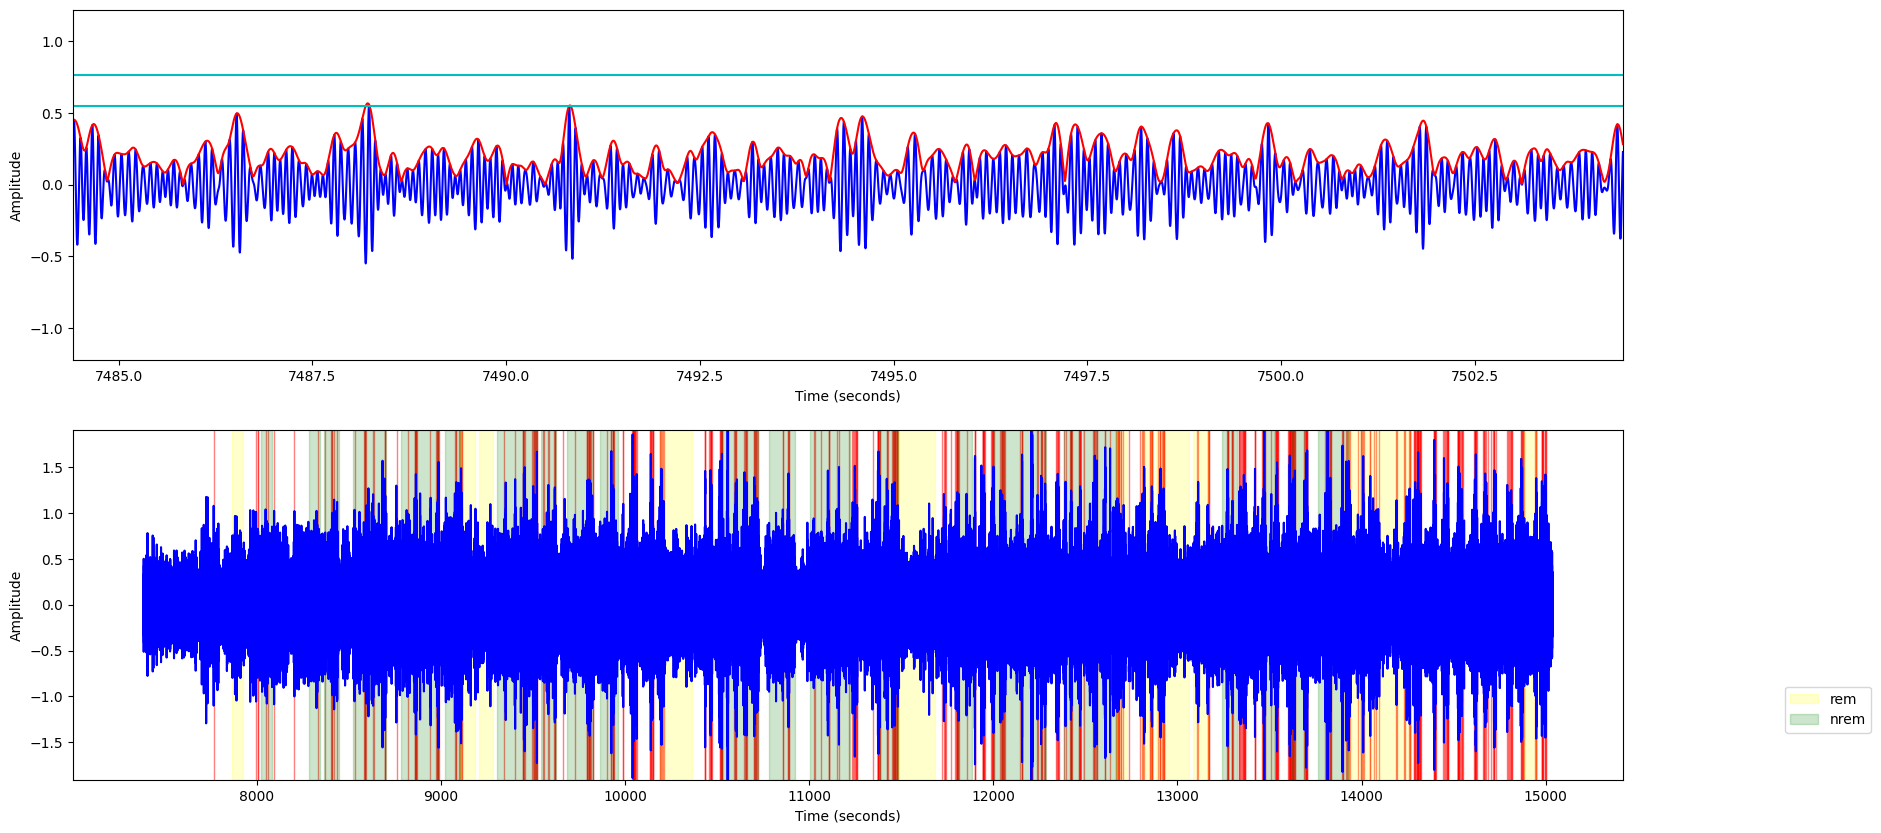

In [36]:
fs = 2500
min_event_duration = 0.3 #s
sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]
spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)


In [ ]:
time = np.arange(len(spindle_bandpassed)) / fs
# adjust time to account for trimmed down ephys lfp
time += sleep_period_ephys_start_time

rem_intervals = rem_start_ends
nrem_intervals = nrem_start_ends
        
## filter for NREM sleep times only and find mean and s-dev
nrem_envelope_perioids = []
for interval in nrem_intervals:
    nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
mean_ = np.mean(nrem_envelope_perioids)
std_ = np.std(nrem_envelope_perioids)

upper_threshold = mean_ + 2*std_
lower_threshold = mean_ + 1*std_

spindle_start_ends = [[event['start_time'],event['end_time']] for event in spindle_events] - sleep_period_ephys_start_time

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)

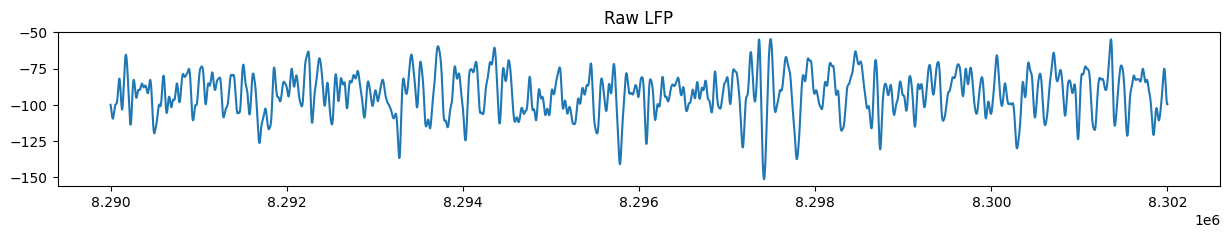

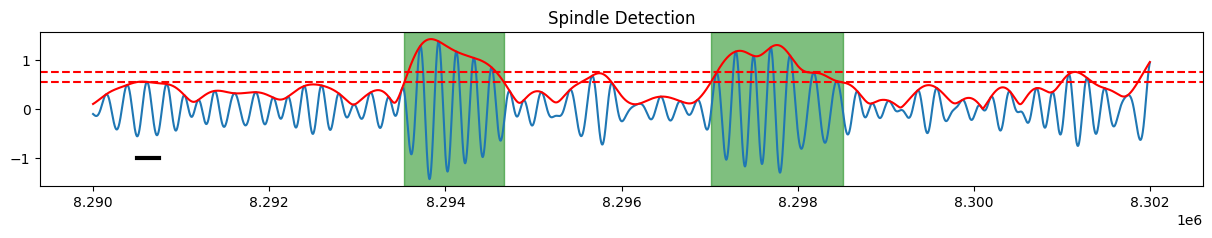

In [129]:

# timeframe = [2560000, 2586000]
# timeframe = [3680000, 3695000]
# timeframe = [7930000, 7950000]
timeframe = [8290000, 8302000]
time_indices = np.arange(timeframe[0], timeframe[1])

# First plot: raw LFP
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(time_indices, average_lfp[timeframe[0]:timeframe[1]])
ax.set_title("Raw LFP")
SaveFig('raw_lfp_example.pdf', r"C:\Users\Emmett Thompson\Documents\plots\\")

# Second plot: bandpassed + envelope + thresholds + spindle spans
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(time_indices, spindle_bandpassed[timeframe[0]:timeframe[1]], label='Bandpassed')
ax.plot(time_indices, smoothed_envelope[timeframe[0]:timeframe[1]], color='r', label='Envelope')
ax.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
ax.axhline(lower_threshold, color='red', linestyle='--', label='Lower Threshold')

# Highlight spindle events within the timeframe
for events in spindle_start_ends * 2500:
    start, end = events
    if start > timeframe[0] and end < timeframe[1]:
        ax.axvspan(start, end, alpha=0.5, color='green')

ax.set_title("Spindle Detection")
# ax.legend()

line_duration = int(2500 / 10)  # 250 samples
start_x = timeframe[0] + 500  # Add some padding from the left edge
end_x = start_x + line_duration

# Choose a y-value near the bottom of your signal (adjust as needed)
y_value = -1  # You can also use np.min(spindle_bandpassed[...]) - margin

ax.plot([start_x, end_x], [y_value, y_value], color='k', linewidth=3)
# ax.text((start_x + end_x)/2, y_value - 20, "0.1 s", ha='center', va='top')



SaveFig('spindle_detection_example.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

In [149]:
def plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,var_string):

    spectral_powers = []
    spectral_timestamps = []
    replay_binned = []
    replay_bin_ts = []
    fig,ax= plt.subplots(1, 1,figsize=(8, 3))
    cumulative_chunk_time = 0

    chunk_dat = replay_events_df[replay_events_df.chunk == 1]
    chunk_time = chunk_dat.chunk_time[0]  

    R_event_fs_times = (chunk_dat.first_spike_time.values) - cumulative_chunk_time
    
    # bin into 1s bins and take replay rate 
    bin_size = 1
    hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
    
    ## add to cumulative chunk time counter 
    cumulative_chunk_time += np.diff(chunk_time)[0]
    
    chunk_delta_spectral_power = np.array(delta_spectral_power)[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]
    chunk_delta_timestamps = delta_timestamps[(np.array(delta_timestamps) >  chunk_time[0]) * (np.array(delta_timestamps) <  chunk_time[1])]

    # Calculate bin centers
    bin_centers = ((bins[:-1] + bins[1:]) / 2) + chunk_time[0]
    
    # Calculate log spectral power
    log_power = np.log10(chunk_delta_spectral_power)
    # Optional: Smooth
    smoothed_log_power = convolve_movmean(log_power, 30)

    ax.plot(chunk_delta_timestamps,smoothed_log_power, 'blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(var_string,color = 'blue')
    ax.set_title(f'{var_string} vs replay rate')
    ax2 = ax.twinx()
    ax2.plot(bin_centers,convolve_movmean(hist,30), color = 'red')
    ax2.set_ylabel('replay rate', color = 'red')
    
    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_start_ends):
        label = 'rem' if ind == 0 else None
        ax.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_start_ends):
        label = 'nrem' if ind == 0 else None
        ax.axvspan(start, end, color='green', alpha=0.2, label=label)
        
    ax.set_xlim(chunk_time[0], chunk_time[1])



    # Move legend off to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    # set the tight layout
    plt.tight_layout()
    
    # pull out the data for other analysis 
    spectral_powers += [chunk_delta_spectral_power]
    spectral_timestamps += [chunk_delta_timestamps]
    replay_binned += [hist]
    replay_bin_ts += [bin_centers]
    
    return spectral_powers, spectral_timestamps, replay_binned, replay_bin_ts

mouse name is: 136_1_3
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
---------------------
searching for replay data
file found: 136_1_3_run_1007023_2048
chunk1_8700to9300
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk2_10000to11600
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk3_11900to12500
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
Success! Loaded replay data files for mouse: 136_1_3.
---------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_15348\1564714663.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_15348\1564714663.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


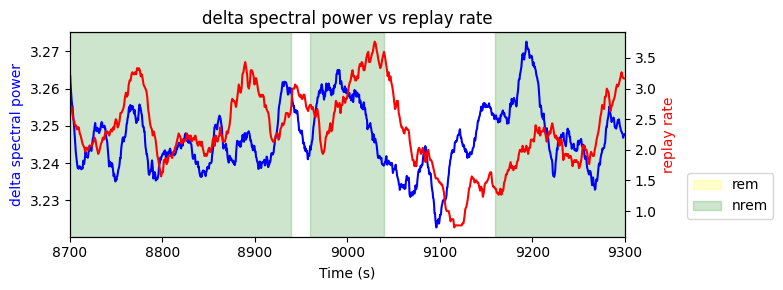

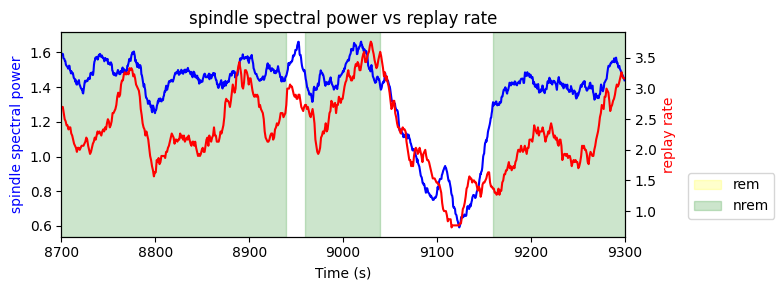

In [150]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

mouse = '136_1_3'

mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
print( f'mouse name is: \033[1m{mouse}\033[0m')
average_lfp = np.load(mouse_data_path + 'average_lfp.npy')

## load in sleep state scoring data
nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)

## load in replay data, for 178_1_7 i will make some example plots so load in the spikes data also
# if mouse == '178_1_7':
#     replay_events_df,spikes_df = load_in_replay_data(mouse,old_data_bool)
# else:
replay_events_df,replay_exists_bool = load_in_replay_data(mouse,old_data_bool)

    
# load sync file
behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    

# SPECTRAL POWER VS REPLAY ##############################

# get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

## detemrine delta spectral power 
fmin = 0.5
fmax = 5
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
delta_spectral_power,delta_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
delta_timestamps += sleep_period_ephys_start_time

# determine spindle spectral power 
fmin = 9
fmax = 16
fs = 2500
window = 1 # seconds
overlap = 0.5 # seconds
spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
spindle_timestamps += sleep_period_ephys_start_time

### plot spectral power vs replay rate 
# delta:
delta_spectral_powers, delta_spectral_timestamps, delta_replay_binned, delta_replay_bin_ts = plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'delta spectral power')      
# save out the fig
SaveFig('delta_example_mouse.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")
# spindle:
spndl_spectral_powers, spndl_spectral_timestamps, spndl_replay_binned, spndl_replay_bin_ts = plot_replay_vs_spectral_power(spindle_spectral_power,spindle_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'spindle spectral power')    
SaveFig('spindle_example_mouse.pdf',r"C:\Users\Emmett Thompson\Documents\plots\\")

# main

mouse name is: 136_1_3
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
---------------------
searching for replay data
file found: 136_1_3_run_1007023_2048
chunk1_8700to9300
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk2_10000to11600
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk3_11900to12500
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
Success! Loaded replay data files for mouse: 136_1_3.
---------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_56040\938921029.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


nrem events per minute: 3.3333333333333335
rem events per minute: 1.25


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_56040\965405734.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist, bins = np.histogram(R_event_fs_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_56040\965405734.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hist2, bins2 = np.histogram(chunk_spin_event_times, bins=np.arange(0, np.diff(chunk_time)+bin_size, bin_size))


 the correlation is from spindles to replay, so I think a peak after indicates that replay proceeds spindles (spindles are lag shifted postivly)
proportion of replay events that are linked to spindles (total) 0.13235986811116346
proportion of replay events that are linked to spindles (nrem) 0.18433734939759036
proportion of replay events that are linked to spindles (rem) 0.0
starting preprocessing for regression analysis...
 - processing chunk number 1
 - processing chunk number 2
 - processing chunk number 3
Optimization terminated successfully.
         Current function value: 0.673405
         Iterations 4


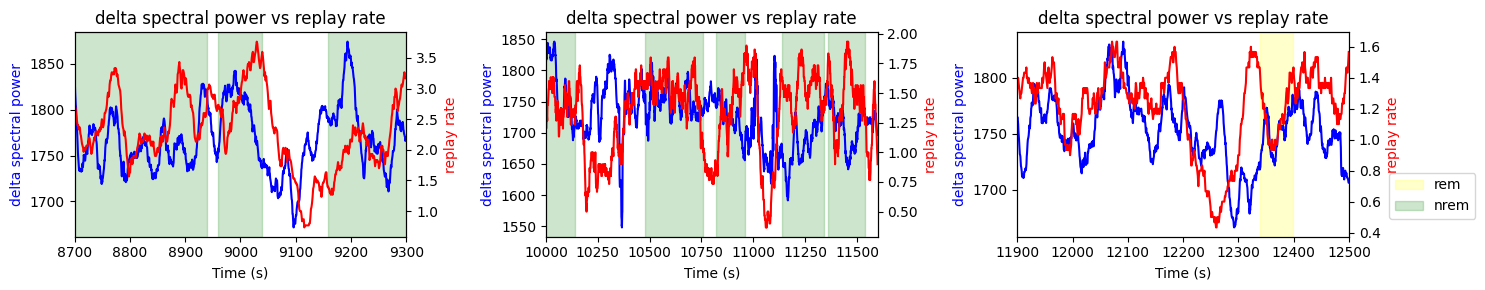

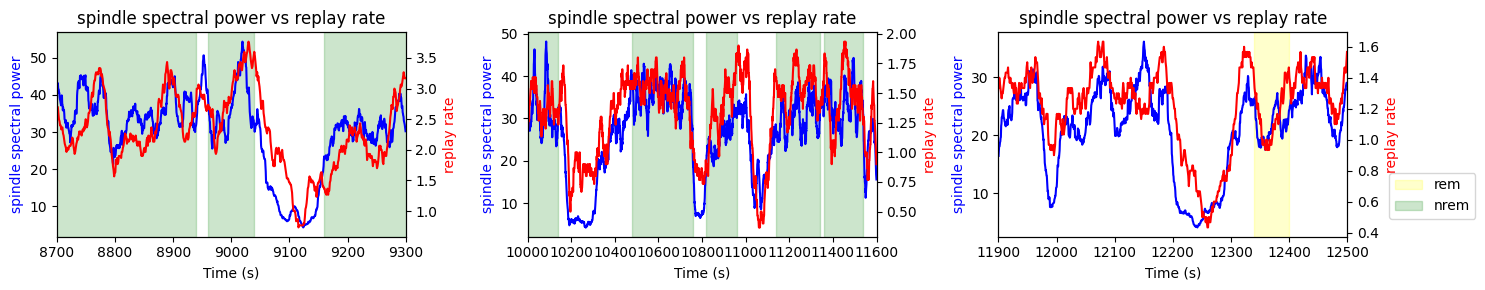

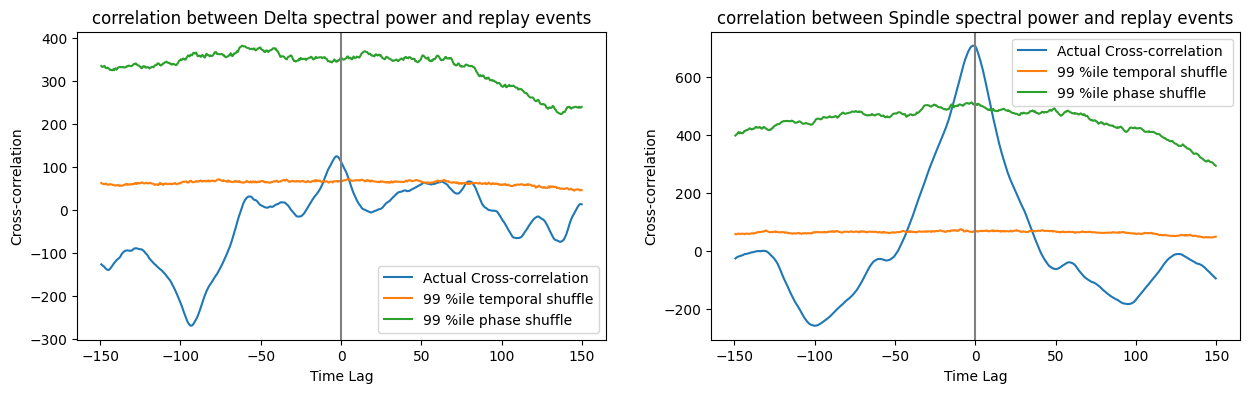

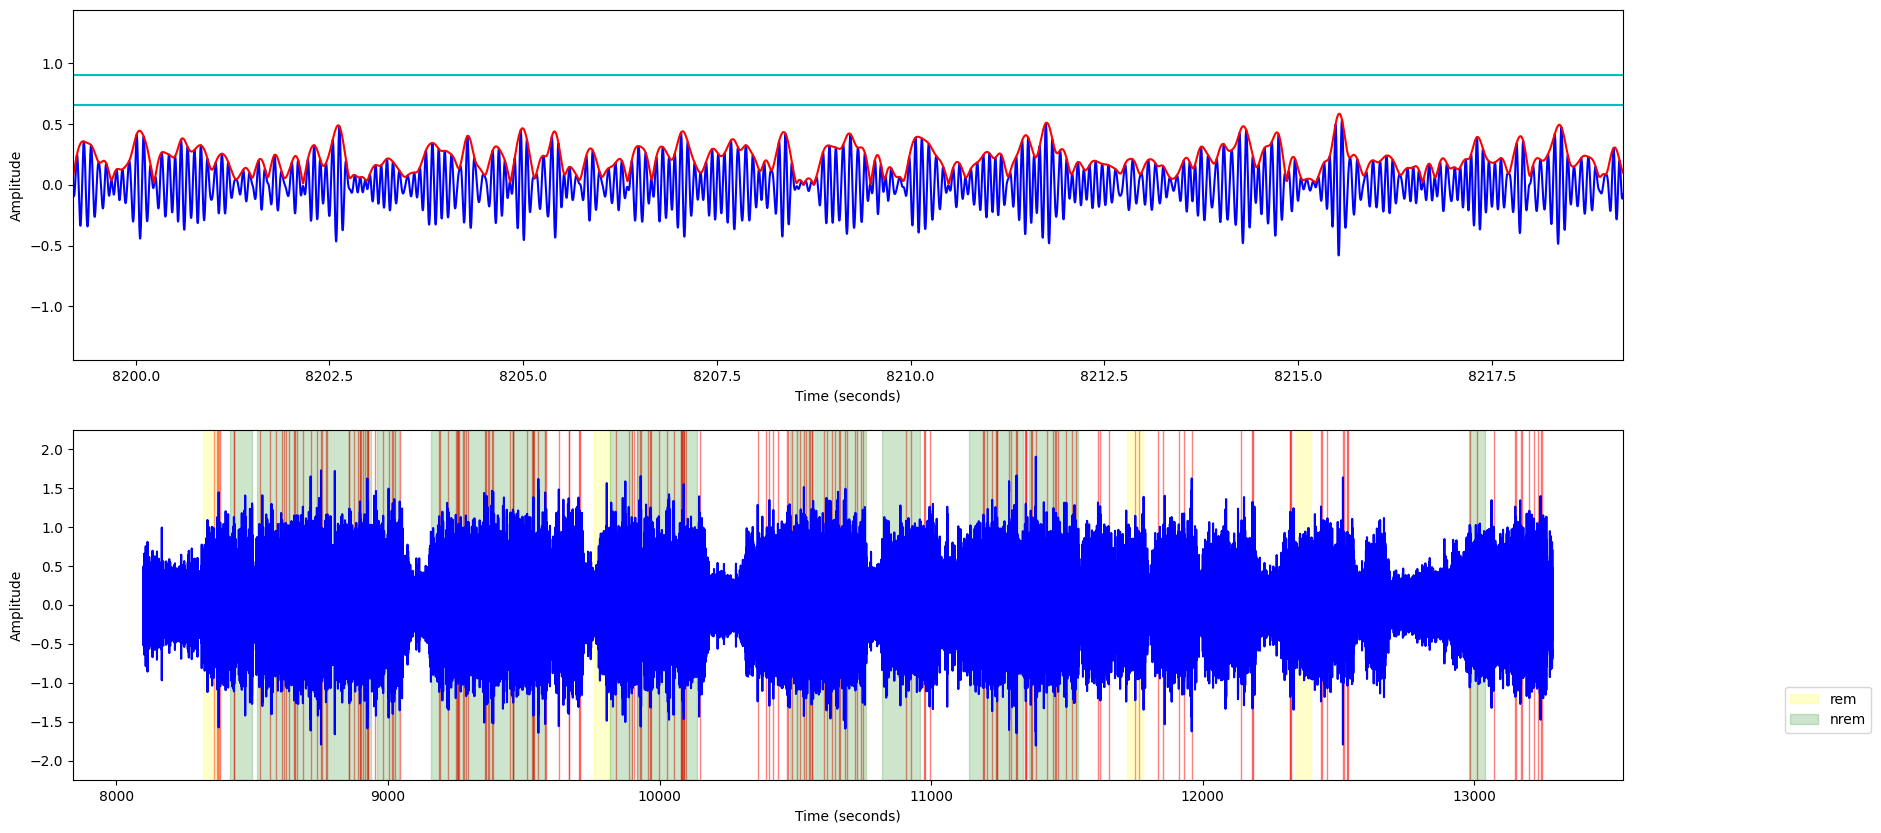

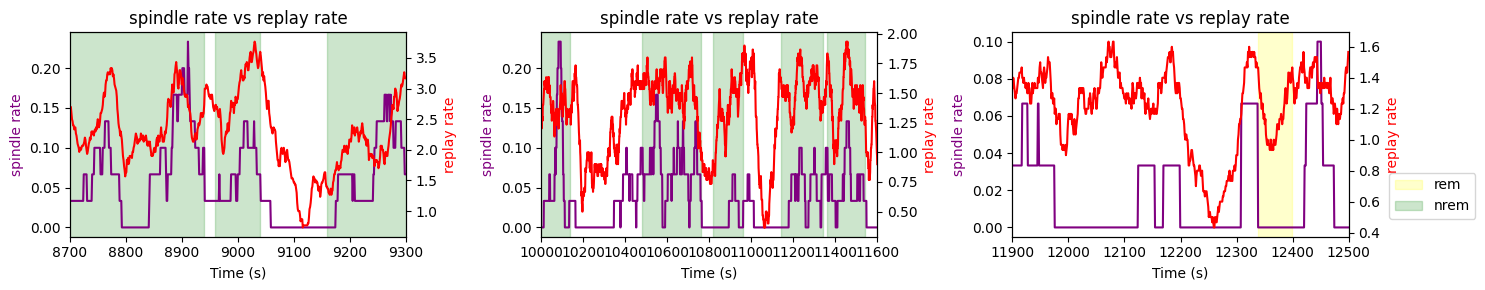

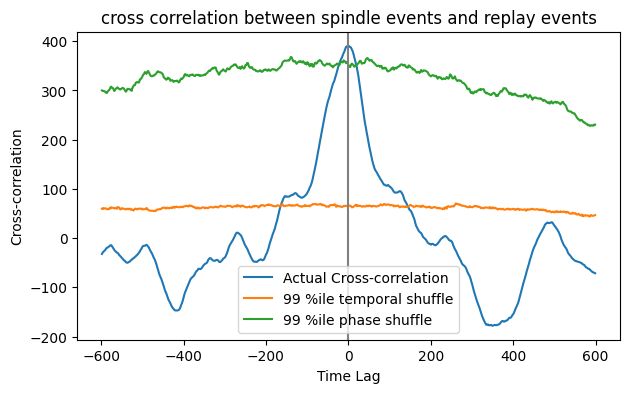

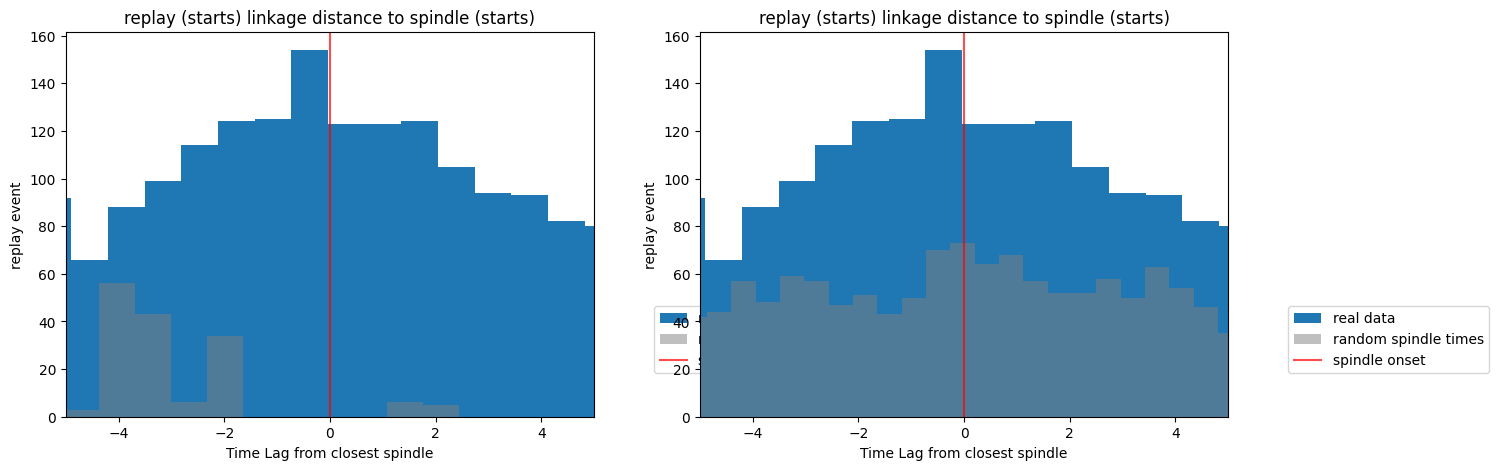

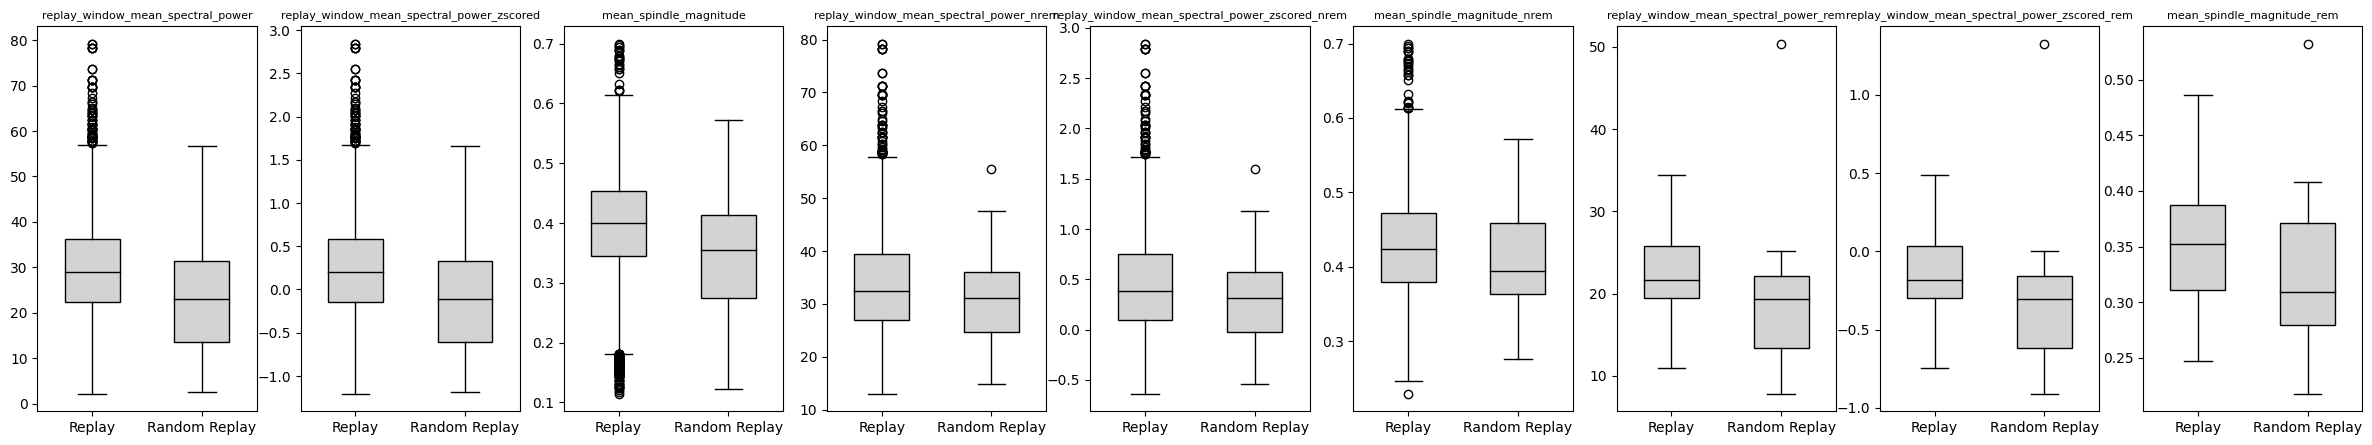

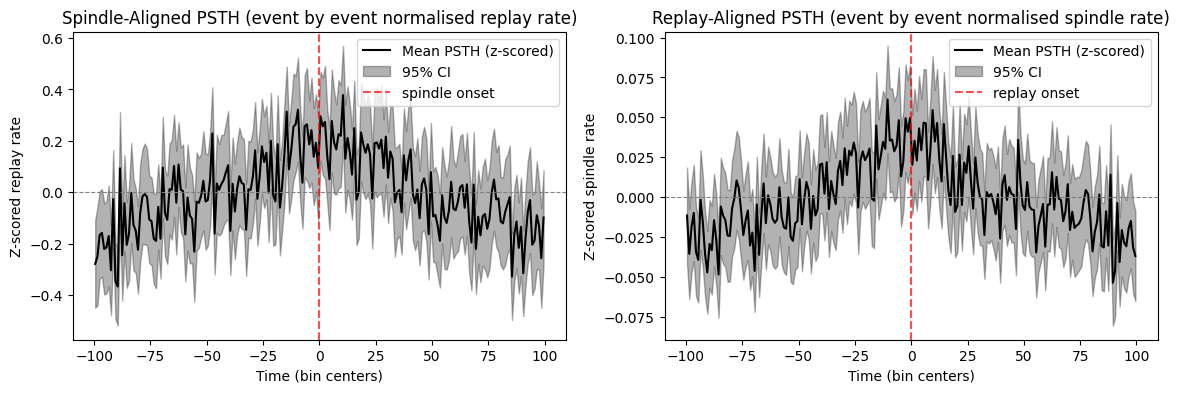

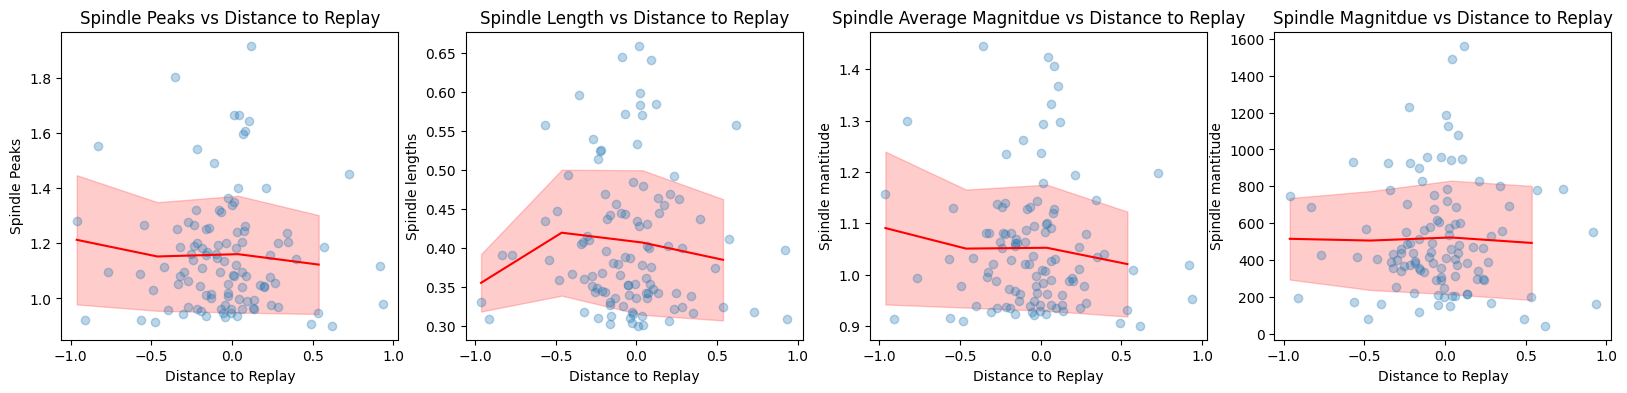

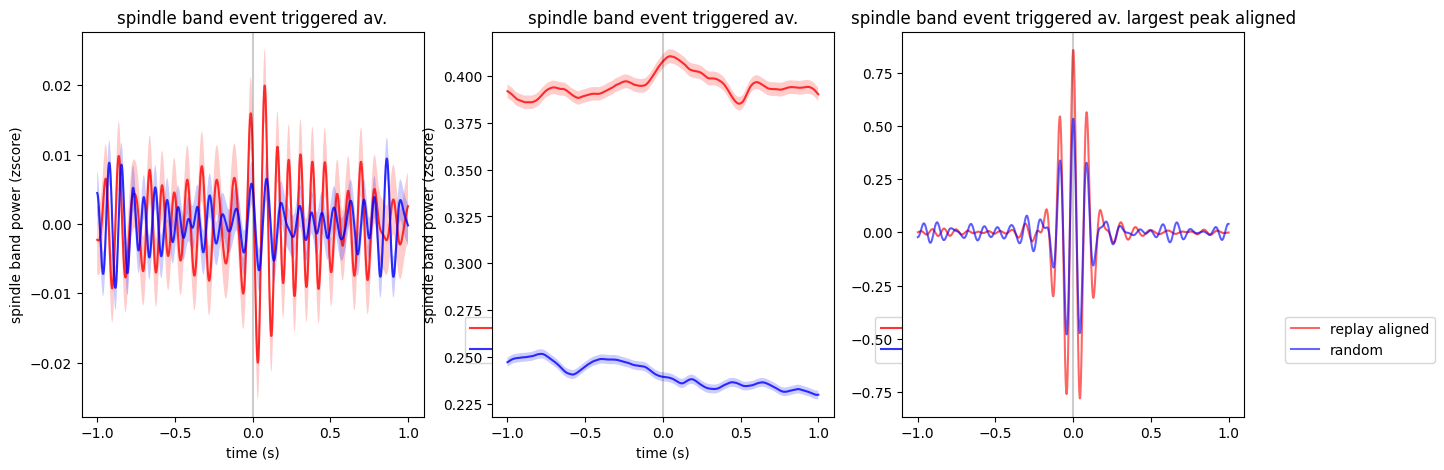

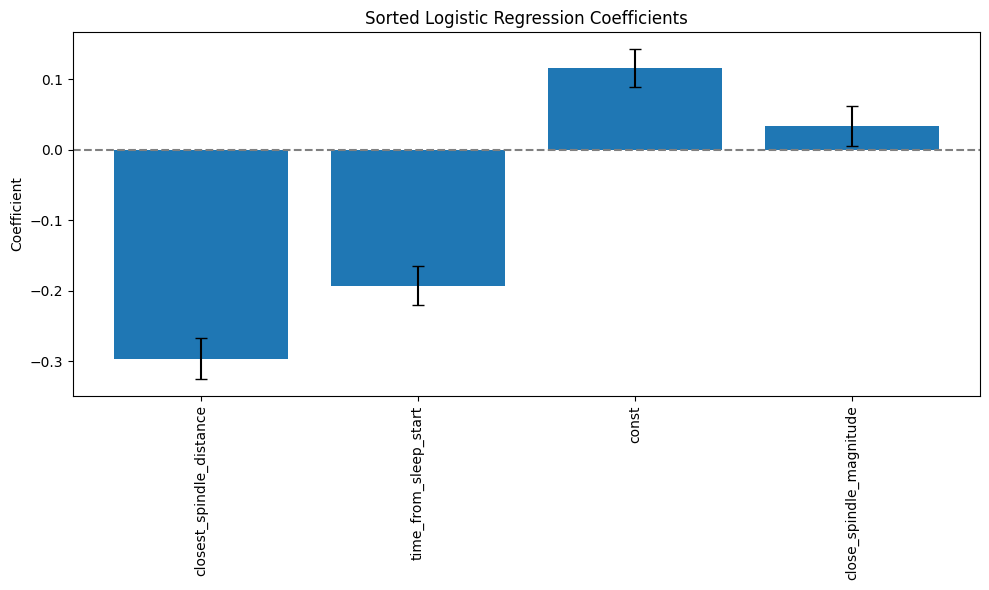

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_56040\2022367687.py:904: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


100%|██████████| 4246/4246 [00:02<00:00, 1746.99it/s]


Optimization terminated successfully.
         Current function value: 0.384712
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     spindle_linage_binary   No. Observations:                 4246
Model:                             Logit   Df Residuals:                     4236
Method:                              MLE   Df Model:                            9
Date:                   Mon, 07 Jul 2025   Pseudo R-squ.:                 0.01570
Time:                           16:34:47   Log-Likelihood:                -1633.5
converged:                          True   LL-Null:                       -1659.5
Covariance Type:               nonrobust   LLR p-value:                 4.311e-08
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8857      0.086    -21.963      0.000      -2.

<Figure size 640x480 with 0 Axes>

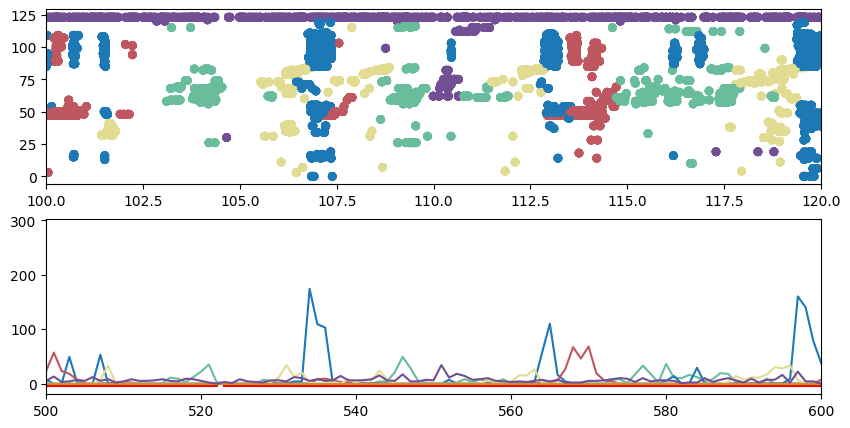

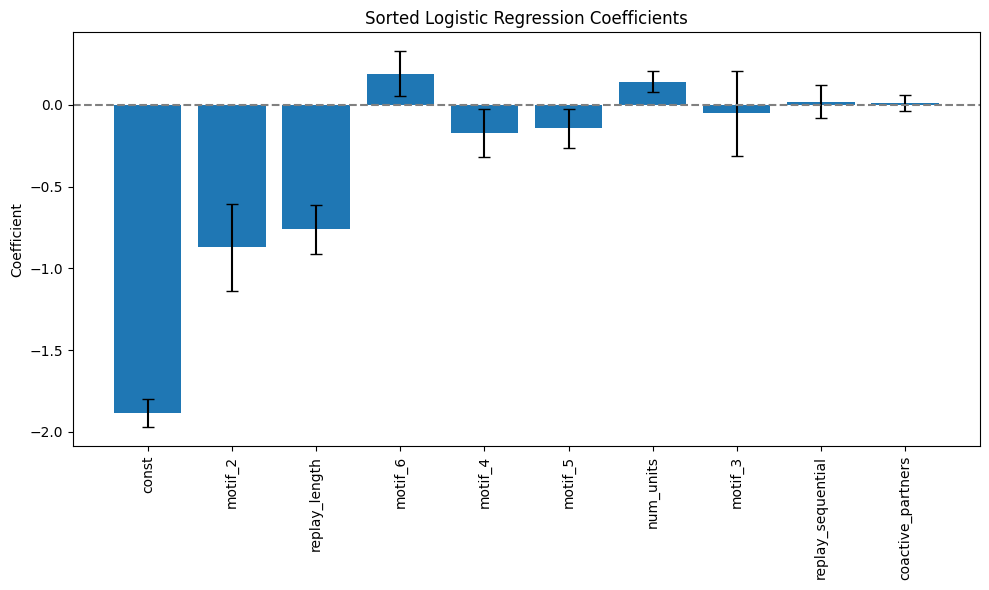

============================================= DONE ===================================================


<Figure size 640x480 with 0 Axes>

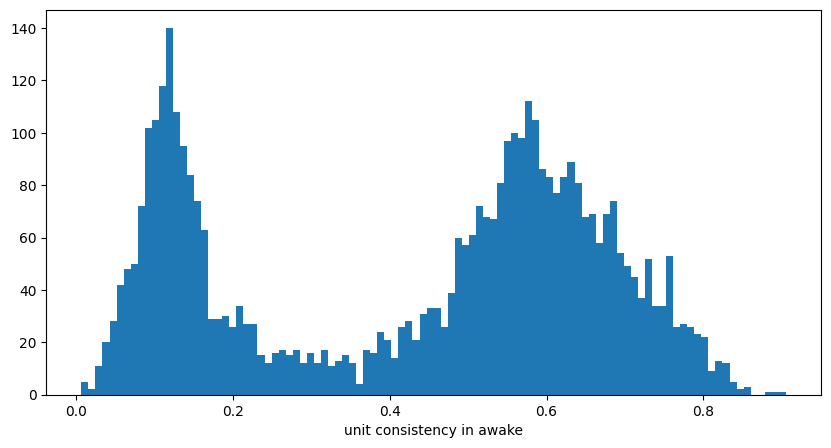

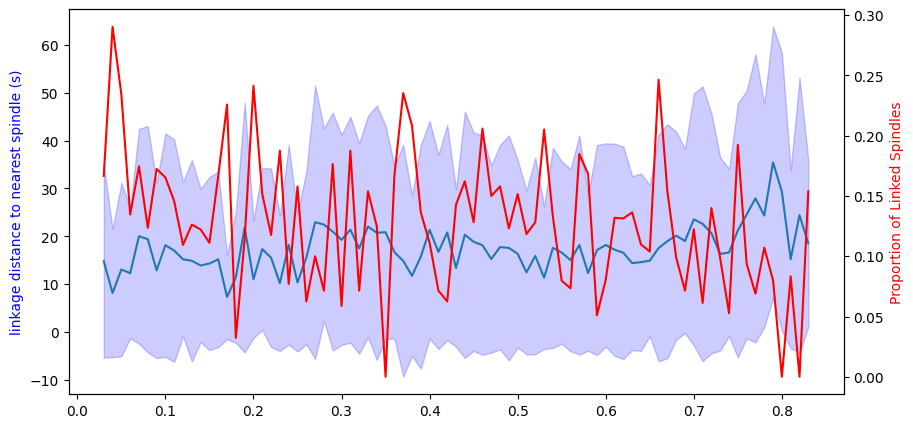

In [4]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

for mouse in os.listdir(data_path):
    mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
    if not os.path.exists(mouse_data_path):
        print(f"Mouse {mouse} does not have processed data.")
        continue
    print( f'mouse name is: \033[1m{mouse}\033[0m')
    average_lfp = np.load(mouse_data_path + 'average_lfp.npy')
    
    ## load in sleep state scoring data
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)
    
    ## load in replay data, for 178_1_7 i will make some example plots so load in the spikes data also
    # if mouse == '178_1_7':
    #     replay_events_df,spikes_df = load_in_replay_data(mouse,old_data_bool)
    # else:
    replay_events_df,replay_exists_bool = load_in_replay_data(mouse,old_data_bool)
    
    if replay_exists_bool == 'SKIP':
        print(f'ERROR! no replay data found for mouse {mouse}')
        print('================================================================================================')
        continue
        
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    
    #make outpath
    output_path = os.path.join(data_path,mouse) + r'\analysis\\'
    # if path doesnt exist, make it
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    

    ####################################################################
    
    # SPECTRAL POWER VS REPLAY ##############################

    # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
    sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

    ## detemrine delta spectral power 
    fmin = 0.5
    fmax = 5
    fs = 2500
    window = 1 # seconds
    overlap = 0.5 # seconds
    delta_spectral_power,delta_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
    delta_timestamps += sleep_period_ephys_start_time

    # determine spindle spectral power 
    fmin = 9
    fmax = 16
    fs = 2500
    window = 1 # seconds
    overlap = 0.5 # seconds
    spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, window,overlap)
    spindle_timestamps += sleep_period_ephys_start_time

    ### plot spectral power vs replay rate 
    # delta:
    delta_spectral_powers, delta_spectral_timestamps, delta_replay_binned, delta_replay_bin_ts = plot_replay_vs_spectral_power(delta_spectral_power,delta_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'delta spectral power')      
    # save out the fig
    plt.savefig(output_path + 'delta_spectral_power_vs_replay.png')
    # spindle:
    spndl_spectral_powers, spndl_spectral_timestamps, spndl_replay_binned, spndl_replay_bin_ts = plot_replay_vs_spectral_power(spindle_spectral_power,spindle_timestamps,replay_events_df,rem_start_ends, nrem_start_ends,'spindle spectral power')    
    plt.savefig(output_path + 'spindle_spectral_power_vs_replay.png')

    # Interpolate data1 values to match data2 timestamps (they have different sample/binning frequencies and are misalined in their binning)
    # i need to do this alignment in order to correlate them
    # delta
    replay_aligned_delta_spectral_powers = []
    for i in range(len(delta_spectral_timestamps)):
        interp_func = interp1d(delta_spectral_timestamps[i], delta_spectral_powers[i], kind='linear', fill_value='extrapolate')
        _interp = interp_func(delta_replay_bin_ts[i])
        replay_aligned_delta_spectral_powers += [_interp]
    # spindle
    replay_aligned_spndl_spectral_powers = []
    for i in range(len(spndl_spectral_timestamps)):
        interp_func = interp1d(spndl_spectral_timestamps[i], spndl_spectral_powers[i], kind='linear', fill_value='extrapolate')
        _interp = interp_func(spndl_replay_bin_ts[i])
        replay_aligned_spndl_spectral_powers += [_interp]


    # delta
    smoothing_window = 20  # over a 20 bin window 
    delta_chunk_cross_corr_actual,delta_chunk_temporal_shuffle,delta_chunk_phase_shuffle = calculate_cross_correlation(replay_aligned_delta_spectral_powers, delta_replay_binned, smoothing_window,num_shuffles=1000)

    # spindle
    smoothing_window = 20  # over a 20 bin window 
    spndl_chunk_cross_corr_actual,spndl_chunk_temporal_shuffle,spndl_chunk_phase_shuffle = calculate_cross_correlation(replay_aligned_spndl_spectral_powers, spndl_replay_binned, smoothing_window,num_shuffles=1000)

    # the significance of the cross correlation is determined by the 99th percentile of the shuffled data.
    # there are two kinds of shuffle:
    # 1. complete temporal shuffle. (random permutation) of the signal. The specral power is randoly shuffled in time. 
    # 2. Phase randomization. scrambles the timing (phase) of each frequency component in a signal while keeping the frequency content (power spectrum) the same. This breaks any temporal alignment or structure (like shared rhythms) while preserving the overall shape and energy of the signal. 
    ### the second one is done by doing a fourier transforms (breaking it down into sine wave components) randomly shifting the phase of the components and then putting it backtogether
    # i thought about and tried a circular shuffle but I think it doesnt make sense because there is undelrying periodicity.


    # Plot the cross-correlation result
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(15, 4))
    data_length = len(delta_chunk_cross_corr_actual[0])
    
    # calculate time lags based on binning size/overlap 
    bin_distance = window - overlap
    bin_multiplier = 1/bin_distance
    time_lags = np.linspace(data_length*-1*bin_distance/bin_multiplier+bin_distance,data_length*bin_distance/bin_multiplier,data_length)
  
    ax.plot(time_lags, np.mean(delta_chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax.plot(time_lags, np.mean(delta_chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax.plot(time_lags, np.mean(delta_chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax.axvline(0,color = 'grey')
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(f'correlation between Delta spectral power and replay events')
    ax.legend()
    ax2.plot(time_lags, np.mean(spndl_chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax2.plot(time_lags, np.mean(spndl_chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax2.plot(time_lags, np.mean(spndl_chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax2.axvline(0,color = 'grey')
    ax2.set_xlabel('Time Lag')
    ax2.set_ylabel('Cross-correlation')
    ax2.set_title(f'correlation between Spindle spectral power and replay events')
    ax2.legend()

    # save out the fig
    plt.savefig(output_path + 'cross_correlation_delta_spindle_replay.png')
        
    # z score the averages to normalise and save out for future across animals anlaysis
    delta_z_x_corr = zscore(np.mean(delta_chunk_cross_corr_actual,axis = 0))
    delta_z_temporal_shuffle = zscore(np.mean(delta_chunk_temporal_shuffle,axis = 0))
    delta_z_phase_shuffle = zscore(np.mean(delta_chunk_phase_shuffle,axis = 0))
    spindle_z_x_corr = zscore(np.mean(spndl_chunk_cross_corr_actual,axis = 0))
    spindle_z_temporal_shuffle = zscore(np.mean(spndl_chunk_temporal_shuffle,axis = 0))
    spindle_z_phase_shuffle = zscore(np.mean(spndl_chunk_phase_shuffle,axis = 0))

    #save out the data
    np.save(output_path + 'delta_z_x_corr.npy',delta_z_x_corr)
    np.save(output_path + 'delta_z_temporal_shuffle.npy',delta_z_temporal_shuffle)
    np.save(output_path + 'delta_z_phase_shuffle.npy',delta_z_phase_shuffle)
    np.save(output_path + 'spindle_z_x_corr.npy',spindle_z_x_corr)
    np.save(output_path + 'spindle_z_temporal_shuffle.npy',spindle_z_temporal_shuffle)
    np.save(output_path + 'spindle_z_phase_shuffle.npy',spindle_z_phase_shuffle)
    np.save(output_path + 'spectral_power_time_lags.npy',time_lags)



    # SPINDLE IDENTIFICATION ##############################

    # load in spindle bandpassed data 
    spindle_bandpassed = np.load(mouse_data_path + 'zscored_spindle_bandpassed.npy')

    # find spindle events
    fs = 2500
    min_event_duration = 0.3 #s
    spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
    plt.savefig(output_path + 'spindle_identification.png')

    ### calculate spindle rate in rem and nrem (nrem should be 2-3 per minute)
    nrem_events_per_minute = determine_spindle_rates(spindle_events,nrem_start_ends)
    rem_events_per_minute = determine_spindle_rates(spindle_events,rem_start_ends)
    print(f'nrem events per minute: {nrem_events_per_minute}')
    print(f'rem events per minute: {rem_events_per_minute}')

    # save this out
    spin_rates = pd.DataFrame({'mouse': [mouse], 'nrem_epm': [nrem_events_per_minute],'rem_epm':[rem_events_per_minute]})
    spin_rates.to_csv(output_path + 'spindle_rates.csv',index = False)


    #############################################################################


    # plot correlation 
    # plot replay rate vs spindle rate
    var_string = 'spindle rate'
    binned_replay_times,binned_spindle_times,bin_centres,bin_distance = plot_replay_vs_spindle_events(spindle_events,replay_events_df,rem_start_ends, nrem_start_ends,var_string)
    plt.savefig(output_path + 'spindle_rate_vs_replay.png')

    # bin the timeseries data
    smoothing_window = 20
    chunk_cross_corr_actual, chunk_temporal_shuffle,chunk_phase_shuffle = calculate_cross_correlation(binned_spindle_times,binned_replay_times, smoothing_window,num_shuffles=1000)

    # Plot the cross-correlation result
    fig,ax= plt.subplots(1, 1,figsize=(7, 4))

    bin_multiplier = 1/bin_distance
    time_lags = np.linspace(data_length*-1*bin_distance/bin_multiplier+bin_distance,data_length*bin_distance/bin_multiplier,data_length)
  
    ax.plot(time_lags, np.mean(chunk_cross_corr_actual,axis = 0), label='Actual Cross-correlation')
    ax.plot(time_lags, np.mean(chunk_temporal_shuffle,axis = 0), label='99 %ile temporal shuffle')
    ax.plot(time_lags, np.mean(chunk_phase_shuffle,axis = 0), label='99 %ile phase shuffle')
    ax.axvline(0,color = 'grey')
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(f'cross correlation between spindle events and replay events')
    ax.legend()
    
    #save this figure out
    plt.savefig(output_path + 'cross_correlation_spindle_events_replay_events.png')
    
    # save the data out
    spindle_z_x_corr = zscore(np.mean(chunk_cross_corr_actual,axis = 0))
    spindle_z_temporal_shuffle = zscore(np.mean(chunk_temporal_shuffle,axis = 0))
    spindle_z_phase_shuffle = zscore(np.mean(chunk_phase_shuffle,axis = 0))
    np.save(output_path + 'spindle_events_z_x_corr_replay.npy',spindle_z_x_corr)
    np.save(output_path + 'spindle_events_z_temporal_shuffle_replay.npy',spindle_z_temporal_shuffle)
    np.save(output_path + 'spindle_events_z_phase_shuffle_replay.npy',spindle_z_phase_shuffle)
    np.save(output_path + 'spindle_events_time_lags_replay.npy',time_lags)
    
    print(' the correlation is from spindles to replay, so I think a peak after indicates that replay proceeds spindles (spindles are lag shifted postivly)')


    ###################################################################


    # SPINDLE REPLAY LINKAGE ANALYSIS ##############################

    ## reset index
    replay_events_df = replay_events_df.reset_index(drop = True)

    # account for cumulative chunk time, make cumulative list
    chunk_times = []
    for chunk_number in replay_events_df.chunk.unique()[0:-1]:
        chunk_ts = replay_events_df.chunk_time[np.where(replay_events_df.chunk == chunk_number)[0][0]]
        chunk_times += [np.diff(chunk_ts)[0]]
    cumulative_chunk_start_times = [0] + list(np.cumsum(chunk_times))

    # pull out replay times (first spike and mid points)
    replay_fs_times = []
    replay_mid_times  = []
    for index, chunktime in enumerate(replay_events_df.chunk_time):
        chunk_cumulative_offset = cumulative_chunk_start_times[replay_events_df.chunk[index] - 1]
        #relative replay time within all chunks
        rel_cumchunks_time = (replay_events_df.first_spike_time[index] - chunk_cumulative_offset)
        # replay time in ephys time
        replay_time_fs_ephys = rel_cumchunks_time + chunktime[0]
        replay_fs_times += [replay_time_fs_ephys]
        # half length of replay
        half_length = (replay_events_df.last_spike_time[index] - replay_events_df.first_spike_time[index])/2 
        replay_mid_times += [replay_time_fs_ephys + half_length]

    #accout for offset (i trimmed the lfp down to just the sleep period during preprocessing to make the data less heavy )
    replay_fs_times = replay_fs_times - sleep_period_ephys_start_time
    replay_mid_times = replay_mid_times - sleep_period_ephys_start_time

    # find spindle mid points
    spindle_start_points = []
    spindle_mid_points = []
    for spin_event in spindle_events:
        spin_length = spin_event['end_time'] - spin_event['start_time']
        spin_mid = (spin_event['start_time']-sleep_period_ephys_start_time) + (spin_length/2)
        spin_start = (spin_event['start_time']-sleep_period_ephys_start_time)
        spindle_start_points += [spin_start]
        spindle_mid_points += [spin_mid]

    # calcuate linkage distance - min distance between spindle and replay event for each replay
    spindle_linkage_distance  = define_spindle_linkage(spindle_start_points,replay_fs_times)
    
    # do the same but for raomised replay/spindle times 
    # define the chunks for when to define random replay events
    chunk_ts = []
    for chunk_number in replay_events_df.chunk.unique():
        chunk_ts += [replay_events_df.chunk_time[np.where(replay_events_df.chunk == chunk_number)[0][0]]]
    # generate random relay times drawn from the same timescale as the replay times (but exlude any times that are too close to a real replay)
    pseudo_random_values = generate_filtered_floats(chunk_ts-sleep_period_ephys_start_time, replay_fs_times, buffer=1.5, num_values=len(replay_fs_times), max_attempts=1000000)
    spindle_linkage_distance_random_replay  = define_spindle_linkage(spindle_start_points,pseudo_random_values)

    # now for random spindle times
    pseudo_random_values = generate_filtered_floats([[min(spindle_start_points),max(spindle_start_points)]], spindle_start_points, buffer=1.5, num_values=len(spindle_start_points), max_attempts=1000000)
    spindle_linkage_distance_random_spindles  = define_spindle_linkage(pseudo_random_values,replay_fs_times)

    ### plot 
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(15, 5))
    x = ax.hist(spindle_linkage_distance,300,label = 'real data')
    x = ax.hist(spindle_linkage_distance_random_replay,300, color = 'grey', alpha = 0.5, label = 'random replay times')
    ax.set_xlabel('Time Lag from closest spindle')
    ax.set_ylabel('replay event')
    ax.set_title('replay (starts) linkage distance to spindle (starts)')
    ax.axvline(0,color = 'red', alpha = 0.7, label = 'spindle onset')
    ax.set_xlim(-5,5)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    x = ax2.hist(spindle_linkage_distance,300, label = 'real data')
    x = ax2.hist(spindle_linkage_distance_random_spindles,300, color = 'grey', alpha = 0.5, label = 'random spindle times')
    ax2.set_xlabel('Time Lag from closest spindle')
    ax2.set_ylabel('replay event')
    ax2.set_title('replay (starts) linkage distance to spindle (starts)')
    ax2.axvline(0,color = 'red', alpha = 0.7, label = 'spindle onset')
    ax2.set_xlim(-5,5)
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))

    # save the figure 
    plt.savefig(output_path + 'spindle_linkage_distance.png')

    ## save out the figure data 
    np.save(output_path + 'spindle_linkage_distance.npy',spindle_linkage_distance)
    np.save(output_path + 'spindle_linkage_distance_random_replay.npy',spindle_linkage_distance_random_replay)
    np.save(output_path + 'spindle_linkage_distance_random_spindles.npy',spindle_linkage_distance_random_spindles)


    ####################################### Spindle Linkage Totals #################################################

    # proportion of replay events that are linked to spindles (in rem and nrem also)
    spindle_start_times = np.array([item['start_time'] for item in spindle_events]) - sleep_period_ephys_start_time
    nrem_periods = nrem_start_ends - sleep_period_ephys_start_time
    rem_periods = rem_start_ends - sleep_period_ephys_start_time

    linked_events = 0
    nrem_events = 0
    linked_nrem_events = 0
    rem_events = 0
    linked_rem_events = 0
    for event in replay_fs_times:
        window = (event - 1.5, event + 1.5)
        mask = (spindle_start_times > window[0]) * (spindle_start_times < window[1])
        if np.sum(mask) > 0:
            linked_events += 1
            
        for period in nrem_periods:
            if (period[0] < event) & (period[1] > event):
                nrem_events += 1
                if np.sum(mask) > 0:
                    linked_nrem_events += 1
        for period in rem_periods:
            if (period[0] < event) & (period[1] > event):
                rem_events += 1
                if np.sum(mask) > 0:
                    linked_rem_events += 1
                
    prop_spin_linked_total = linked_events / len(replay_fs_times)
    if nrem_events > 0 :
        prop_spin_linked_nrem = linked_nrem_events / nrem_events
    else:
        prop_spin_linked_nrem = 0
    if rem_events > 0:
        prop_spin_linked_rem = linked_rem_events / rem_events
    else:
        prop_spin_linked_rem = 0

    print(f'proportion of replay events that are linked to spindles (total) {prop_spin_linked_total}')
    print(f'proportion of replay events that are linked to spindles (nrem) {prop_spin_linked_nrem}')
    print(f'proportion of replay events that are linked to spindles (rem) {prop_spin_linked_rem}')

    # save out this data 
    np.save(output_path + 'proportion_of_spin_linked_replay_total_nrem_rem.npy',[prop_spin_linked_total,prop_spin_linked_nrem,prop_spin_linked_rem])


    ######################## get values for spindle power and magnitude during replay windows ##########################

    # Precompute
    spectral_power_timestamps = np.asarray(spindle_timestamps - sleep_period_ephys_start_time)
    spindle_spectral_power = np.asarray(spindle_spectral_power)
    zscored_spectral_power = zscore(spindle_spectral_power)

    envelope_timestamps = np.arange(len(smoothed_envelope)) / fs
    smoothed_envelope = np.asarray(smoothed_envelope)

    nrem_bounds = np.array(nrem_periods)
    rem_bounds = np.array(rem_periods)


    ## call the function to get spindle power + megnitude during replay windows
    # real replay
    replay_window_results = get_spindle_power_magnitude_during_replay_windows(replay_fs_times,spectral_power_timestamps,spindle_spectral_power,zscored_spectral_power,smoothed_envelope,envelope_timestamps,nrem_bounds,rem_bounds)
    #random replay
    rand_replay_window_results = get_spindle_power_magnitude_during_replay_windows(pseudo_random_values,spectral_power_timestamps,spindle_spectral_power,zscored_spectral_power,smoothed_envelope,envelope_timestamps,nrem_bounds,rem_bounds)

    fig, ax = plt.subplots(1, len(list(replay_window_results)), figsize=(30, 5))
    for index,key in enumerate(replay_window_results):
        # ax[index].plot(np.zeros(len(replay_window_results[key]),), replay_window_results[key], 'o', alpha=0.3, color = 'black')
        # ax[index].plot(np.ones(len(rand_replay_window_results[key]),), rand_replay_window_results[key], 'o', alpha=0.3, color = 'red')
        # create box plots 
        ax[index].boxplot([replay_window_results[key], rand_replay_window_results[key]], positions=[0., 1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightgray', color='black'), medianprops=dict(color='black'))
        # change the x labels
        ax[index].set_xticks([0, 1])
        ax[index].set_xticklabels(['Replay', 'Random Replay'])
            
        ax[index].set_title(key, fontsize=8)

    # save fig 
    plt.savefig(output_path + 'spindle_power_magnitude_during_replay_windows.png')

    # save data:
    np.save(output_path + 'replay_window_results.npy', replay_window_results, allow_pickle=True)
    np.save(output_path + 'rand_replay_window_results.npy', rand_replay_window_results, allow_pickle=True)
        
        
    ###################### PSTH - for each eventA (spindle or replay) what was the average (event by event) rate of event B (replay or spindle) in the window around event A

    # get all the spindles that occured during replay analysis chunks
    chunk_spindles = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        chunk_spindles += list(np.array(spindle_start_points)[(np.array(spindle_start_points) > interval[0]) * (np.array(spindle_start_points) < interval[1])])
    
    # chunk_spindles = []
    # for interval in chunk_ts - sleep_period_ephys_start_time:
    #     chunk_spindles += list(np.array(spindle_mid_points)[(np.array(spindle_mid_points) > interval[0]) * (np.array(spindle_mid_points) < interval[1])])
    
    
    # compute event by event, zscored replay rate per spindle
    bin_size = 1
    event_by_event_psth_spin,bin_centers_spin = event_by_event_zscored_psth(replay_fs_times, chunk_spindles,window=(-100, 100), bin_size = bin_size)

    # Mean and standard deviation across trials 
    mean_psth_spin = np.nanmean(event_by_event_psth_spin, axis=0)
    std_psth_spin = np.nanstd(event_by_event_psth_spin, axis=0)
    n_trials_spin = len(event_by_event_psth_spin)
    stderr_psth_spin = std_psth_spin / np.sqrt(n_trials_spin)
    # Compute 95% confidence intervals
    ci95_upper_spin = mean_psth_spin + 1.96 * stderr_psth_spin
    ci95_lower_spin = mean_psth_spin - 1.96 * stderr_psth_spin

    # Plotting
    fig,[ax,ax2]= plt.subplots(1, 2,figsize=(14, 4))
    ax.plot(bin_centers_spin, mean_psth_spin, label='Mean PSTH (z-scored)', color='k')
    ax.fill_between(bin_centers_spin, ci95_lower_spin, ci95_upper_spin, alpha=0.3, color='k', label='95% CI')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'spindle onset')
    ax.set_xlabel('Time (bin centers)')
    ax.set_ylabel('Z-scored replay rate')
    ax.set_title('Spindle-Aligned PSTH (event by event normalised replay rate)')
    ax.legend()


    #### same again but inverse

    # compute event by event, zscored replay rate per spindle
    bin_size = 1
    event_by_event_psth_rply,bin_centers_rply = event_by_event_zscored_psth(chunk_spindles,replay_fs_times,window=(-100, 100), bin_size = bin_size)

    # Mean and standard deviation across trials 
    mean_psth_rply = np.nanmean(event_by_event_psth_rply, axis=0)
    std_psth_rply = np.nanstd(event_by_event_psth_rply, axis=0)
    n_trials_rply = len(event_by_event_psth_rply)
    stderr_psth_rply = std_psth_rply / np.sqrt(n_trials_rply)
    # Compute 95% confidence intervals
    ci95_upper_rply = mean_psth_rply + 1.96 * stderr_psth_rply
    ci95_lower_rply = mean_psth_rply - 1.96 * stderr_psth_rply

    # Plotting

    ax2.plot(bin_centers_rply, mean_psth_rply, label='Mean PSTH (z-scored)', color='k')
    ax2.fill_between(bin_centers_rply, ci95_lower_rply, ci95_upper_rply, alpha=0.3, color='k', label='95% CI')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax2.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'replay onset')
    ax2.set_xlabel('Time (bin centers)')
    ax2.set_ylabel('Z-scored spindle rate')
    ax2.set_title('Replay-Aligned PSTH (event by event normalised spindle rate)')
    ax2.legend()

    # save the figure 
    plt.savefig(output_path + 'PSTH_event_by_event.png')

    ## save out the figure data 
    np.save(output_path + 'event_by_event_zscored_psth_spindles.npy', event_by_event_psth_spin, allow_pickle=True)
    np.save(output_path + 'event_by_event_psth_spindle_bins.npy', bin_centers_spin, allow_pickle=True)
    np.save(output_path + 'event_by_event_zscored_psth_replay.npy', event_by_event_psth_rply, allow_pickle=True)
    np.save(output_path + 'event_by_event_psth_replay_bins.npy', bin_centers_rply, allow_pickle=True)


    #######################################################################################




    ####### spindle amplitude and magnitude vs proximty to replay

    # exrtract varaibles from spindle events
    spind_starts = np.array([item['start_time'] for item in spindle_events]) - sleep_period_ephys_start_time
    spind_ends = np.array([item['end_time'] for item in spindle_events]) - sleep_period_ephys_start_time
    spind_peaks = np.array([item['peak_magnitude'] for item in spindle_events])
    spind_av_magnitudes = np.array([item['average_magnitude'] for item in spindle_events])
    spind_total_magnitudes = np.array([item['magnitude'] for item in spindle_events])
    # find the chunk relevant data 
    chunk_spind_starts = []
    chunk_spind_ends = []
    chunk_spind_peaks = []
    chunk_spind_av_magnitudes = []
    chunk_spind_lengths = []
    chunk_spind_total_magnitudes = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        mask = (np.array(spind_starts) > interval[0]) * (np.array(spind_starts) < interval[1])
        chunk_spind_starts += list(spind_starts[mask])
        chunk_spind_ends += list(spind_ends[mask])
        chunk_spind_lengths += list(spind_ends[mask] - spind_starts[mask])
        chunk_spind_peaks += list(spind_peaks[mask])
        chunk_spind_total_magnitudes += list(spind_total_magnitudes[mask])
        chunk_spind_av_magnitudes += list(spind_av_magnitudes[mask])

    # calculate distance to replay 
    distance_to_replay = []
    for spin_start in chunk_spind_starts:
        distance, closest_replay = closest_distance(spin_start, replay_fs_times)
        distance_to_replay += [distance]
        
        
    ###################################################################


    ## plot this stuff 

    fig,[ax,ax2,ax3, ax4]= plt.subplots(1, 4,figsize=(20, 4))

    # Compute smoothed data
    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_peaks, window_size=0.5, step_size=0.5)
    ax.plot(distance_to_replay, chunk_spind_peaks, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax.set_xlabel('Distance to Replay')
    ax.set_ylabel('Spindle Peaks')
    ax.set_title('Spindle Peaks vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_lengths, window_size=0.5, step_size=0.5)
    ax2.plot(distance_to_replay, chunk_spind_lengths, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax2.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax2.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax2.set_xlabel('Distance to Replay')
    ax2.set_ylabel('Spindle lengths')
    ax2.set_title('Spindle Length vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_av_magnitudes, window_size=0.5, step_size=0.5)
    ax3.plot(distance_to_replay, chunk_spind_av_magnitudes, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax3.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax3.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax3.set_xlabel('Distance to Replay')
    ax3.set_ylabel('Spindle mantitude')
    ax3.set_title('Spindle Average Magnitdue vs Distance to Replay')

    center_x, means, stds = compute_sliding_window_smooth(distance_to_replay, chunk_spind_total_magnitudes, window_size=0.5, step_size=0.5)
    ax4.plot(distance_to_replay, chunk_spind_total_magnitudes, 'o', alpha=0.3)
    # Plot smoothed curve with mean and std shading
    ax4.plot(center_x, means, 'r-', label='Mean (Sliding Window)')
    ax4.fill_between(center_x, means - stds, means + stds, color='r', alpha=0.2, label='±1 STD')
    ax4.set_xlabel('Distance to Replay')
    ax4.set_ylabel('Spindle mantitude')
    ax4.set_title('Spindle Magnitdue vs Distance to Replay')

    ## save the figure 
    plt.savefig(output_path + 'spindle_features_vs_distance_to_replay.png')

    # ## save the plotting data out
    np.save(output_path + 'distance_to_replay.npy', distance_to_replay)
    np.save(output_path + 'chunk_spind_peaks.npy', chunk_spind_peaks)
    np.save(output_path + 'chunk_spind_lengths.npy', chunk_spind_lengths)
    np.save(output_path + 'chunk_spind_av_magnitudes.npy', chunk_spind_av_magnitudes)
    np.save(output_path +  'chunk_spind_total_magnitude.npy',chunk_spind_total_magnitudes)


    #################### ETA's #######################################################################



    # generate random relay times drawn from the same timescale as the replay times (but exlude any times that are too close to a real replay)
    pseudo_random_values = generate_filtered_floats(chunk_ts-sleep_period_ephys_start_time, replay_fs_times, buffer=1.5, num_values=len(replay_fs_times), max_attempts=1000000)
    ### event triggered average signals 
    average_signal,average_signal_rect,peak_algined_average_signal, peak_sems,random_average_signal,random_average_signal_rect,random_peak_algined_average_signal,random_peak_sems = plot_spindle_etas(replay_fs_times,pseudo_random_values,spindle_bandpassed,smoothed_envelope)

    ## save the figure 
    plt.savefig(output_path + 'spindle_event_triggered_average_signals.png')

    # # save out the data
    np.save(output_path + 'average_signal.npy',average_signal, allow_pickle=True)
    np.save(output_path + 'average_signal_rect.npy',average_signal_rect, allow_pickle=True)
    np.save(output_path + 'peak_algined_average_signal.npy',peak_algined_average_signal, allow_pickle=True)
    np.save(output_path + 'peak_sems.npy',peak_sems, allow_pickle=True)
    np.save(output_path + 'random_average_signal.npy',random_average_signal, allow_pickle=True)
    np.save(output_path + 'random_average_signal_rect.npy',random_average_signal_rect, allow_pickle=True)
    np.save(output_path + 'random_peak_algined_average_signal.npy',random_peak_algined_average_signal, allow_pickle=True)
    np.save(output_path + 'random_peak_sems.npy',random_peak_sems, allow_pickle=True)


    ##########################################################################


    ### sort out data for the regression analysis, the data is put into bins and the regression analyses the data bin by bin (bins are indipendent of each other)
    # this means I can just process these chunk by chunk and then concatenate them together at the end
    print('starting preprocessing for regression analysis...')

    ## bin size for regression analysis
    bin_size = 0.5 # seconds


    # extract spindle features
    spindle_start_points = []
    spindle_mid_points = []
    spin_lengths = []
    spindle_magnitudes = []
    spindle_peaks = []
    for spin_event in spindle_events:
        spin_lengths += [spin_event['end_time'] - spin_event['start_time']]
        spin_mid = (spin_event['start_time']-sleep_period_ephys_start_time) + (spin_length/2)
        spin_start = (spin_event['start_time']-sleep_period_ephys_start_time)
        spindle_start_points += [spin_start]
        spindle_mid_points += [spin_mid]
        spindle_magnitudes += [spin_event['magnitude']]
        spindle_peaks += [spin_event['peak_magnitude']]


    # re-determine spindle spectral power, incase the bin size is different to the one used above
    fmin = 9
    fmax = 16
    fs = 2500
    spindle_spectral_power,spindle_timestamps = determine_spectral_power(average_lfp,fmin,fmax,fs, bin_size*2,bin_size)
    spindle_timestamps += sleep_period_ephys_start_time

    # get all the spindles that occured during replay analysis chunks
    chunk_spindles = []
    chunk_spindle_lengths = []
    chunk_spindle_magnitudes = []
    chunk_spindle_peaks = []
    for interval in chunk_ts - sleep_period_ephys_start_time:
        mask = (np.array(spindle_start_points) > interval[0]) * (np.array(spindle_start_points) < interval[1])
        chunk_spindles += [list(np.array(spindle_start_points)[mask])]
        chunk_spindle_lengths += [list(np.array(spin_lengths)[mask])]
        chunk_spindle_magnitudes += [list(np.array(spindle_magnitudes)[mask])]
        chunk_spindle_peaks += [list(np.array(spindle_peaks)[mask])]    
        
    # get the spindle spectral power for each chunk
    chunk_spindle_specral_powers = []
    for interval in chunk_ts:
        mask = (spindle_timestamps > interval[0]) * (spindle_timestamps < interval[1])
        chunk_spindle_specral_powers += [list(np.array(spindle_spectral_power)[mask])]


    #dependent variables for regression analysis
    allchunks_binned_replay = []
    allchunks_logistic_binned_replay = []

    #independent variables for regression analysis
    allchunks_binned_spindles = []
    allchunks_current_chunk_spindle_specral_powers = []
    allchunks_time_since_spindle = []
    allchunks_time_to_next_spindle = []
    allchunks_close_spindle_peak_size = []
    allchunks_close_spindle_magnitude = []
    allchunks_close_spindle_length = []
    allchunks_time_from_sleep_start = []
    allchunks_REM_periods = []
    allchunks_NREM_periods = []
    allchunks_Other_periods = []
    all_chunks_closest_spindle_distance = []


    # MAIN loop across chunks
    for chunk_number in replay_events_df.chunk.unique():
        print(f' - processing chunk number {chunk_number}')
        chunk_replay_df = replay_events_df[replay_events_df.chunk == chunk_number]
        chunk_replay_fs_times = chunk_replay_df.first_spike_time.values
        
        # get the spindle times for this chunk
        current_chunk_spindles = chunk_spindles[chunk_number-1]
        
        #rebase, replay is in chunk time, spindle is in ephys time
        chunk_replay_fs_times = chunk_replay_fs_times - cumulative_chunk_start_times[chunk_number-1]
        current_chunk_spindles = current_chunk_spindles - (chunk_ts - sleep_period_ephys_start_time)[chunk_number-1][0]
        
        # resort replay in time 
        chunk_replay_fs_times = np.sort(chunk_replay_fs_times)
        
        #bin replay times
        #### Bin replay and spindles - counts per bin
        # Compute bin edges from 0 to just past the max event time
        bins = np.arange(0, np.diff(chunk_ts[chunk_number-1])[0] + bin_size, bin_size)
        ############### bin replay
        binned_replay, bin_edges = np.histogram(chunk_replay_fs_times, bins=bins)
        ############### bin spindles
        binned_spindles, bin_edges = np.histogram(current_chunk_spindles, bins=bins)
        # get bin centres from bin edges
        bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2

        ################  bin in a logistic way (1 if replay, 0 if no replay in bin)
        logistic_binned_replay, logistic_bin_centres = logistic_binning(chunk_replay_fs_times,bins)
        
        ################ specral power for this chunk - already binned in the same way as the replay and spindle data
        current_chunk_spindle_specral_powers = chunk_spindle_specral_powers[chunk_number-1]
        
        
        ################# time since last spindle + time to next spindle & closest spindle peak size/length/magnitude  (if spindle is within 3s of replay), otherwise zero 
        
        
        ## get all the spindles for all times
        all_spindles_starts = [item['start_time'] for item in spindle_events] - sleep_period_ephys_start_time
        all_spindles_ends = [item['end_time'] for item in spindle_events] - sleep_period_ephys_start_time
        all_spindles_peaks = [item['peak_magnitude'] for item in spindle_events]
        all_spindles_magnitudes = [item['magnitude'] for item in spindle_events]
        all_spindles_legnths = [item['end_time'] - item['start_time'] for item in spindle_events]


        ################# time since last spindle + time to next spindle 
        time_since_spindle = []
        time_to_next_spindle = []
        closest_spindle_distance = []

        ################# closest spindle peak size/length/magnitude  (if spindle is within 3s of replay), otherwise zero 
        close_spindle_peak_size = []
        close_spindle_magnitude = []
        close_spindle_length = []


        # get the chunk time for this chunk
        chunk_real_time = chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time
        # move to the middle of the bin
        chunk_real_time = chunk_real_time + bin_size/2
        for index,replay_bool in enumerate(binned_replay):
            
            # # time since spindle 
            # closest_spindle = min(all_spindles_starts[all_spindles_starts < chunk_real_time], key=lambda x: abs(x - chunk_real_time))
            # time_since_spindle += [chunk_real_time - closest_spindle]
            # # time to next spindle
            # closest_spindle = min(all_spindles_starts[all_spindles_starts > chunk_real_time], key=lambda x: abs(x - chunk_real_time))
            # time_to_next_spindle += [closest_spindle - chunk_real_time]
            
            # closest spindle distance
            closest_spindle_distance += [min(abs(all_spindles_starts - chunk_real_time))]
            
            # find closest replay events to this bin time    
            window_mask = (all_spindles_starts > chunk_real_time - 1.5)*(all_spindles_starts < chunk_real_time + 1.5)
            spindles_within_window = all_spindles_starts[window_mask]

            if len(spindles_within_window) == 0:
                close_spindle_peak_size += [0]
                close_spindle_magnitude += [0]
                close_spindle_length += [0]
            elif len(spindles_within_window) > 0:
                # get the index of the closest spindle to the replay event
                closest_spindle = min(spindles_within_window, key=lambda x: abs(x - chunk_real_time))
                # find the variables for the spindle that is closest to the replay event
                close_spindle_peak_size += [np.array(all_spindles_peaks)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
                close_spindle_magnitude += [np.array(all_spindles_magnitudes)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
                close_spindle_length += [np.array(all_spindles_legnths)[window_mask][np.where(spindles_within_window == closest_spindle)[0][0]]]
            
            # add the bin size to the time for the next cycle 
            chunk_real_time += bin_size

            
                        
        ########## # time from sleep onset
        
        rem_intervals = list(rem_start_ends - sleep_period_ephys_start_time)
        nrem_intervals = list(nrem_start_ends - sleep_period_ephys_start_time)
        # take the first items
        sleep_start_time = min([item[0] for item in (rem_intervals + nrem_intervals)])
        for index,replay_bool in enumerate(binned_replay):
            if index == 0:
                time_from_sleep_start = [((chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time) - sleep_start_time) + bin_size]
            else:
                time_from_sleep_start += [time_from_sleep_start[-1] + bin_size]
        
        ############ sleep stage  (nrem or rem)
        
        # get the chunk time for this chunk
        chunk_real_time = chunk_ts[chunk_number-1][0] - sleep_period_ephys_start_time
        # move to the middle of the bin
        chunk_real_time = chunk_real_time + bin_size/2

        REM_periods = []
        NREM_periods = []
        Other_periods = []
        for index,replay_bool in enumerate(binned_replay):
            
            current_sleep_stage = ['None']
            for interval in rem_intervals:
                if (interval[0] < chunk_real_time) * (interval[1] > chunk_real_time):
                    current_sleep_stage = ['REM']
                    break
            for interval in nrem_intervals:
                if (interval[0] < chunk_real_time) * (interval[1] > chunk_real_time):
                    current_sleep_stage = ['NREM']
                    break
                
            if current_sleep_stage == ['None']:
                Other_periods += [1]
                REM_periods += [0]
                NREM_periods += [0]
            elif current_sleep_stage == ['REM']:
                REM_periods += [1]
                Other_periods += [0]
                NREM_periods += [0]
            elif current_sleep_stage == ['NREM']:
                NREM_periods += [1]
                Other_periods += [0]
                REM_periods += [0]

            chunk_real_time += bin_size
            
            

        # concatenate the data for this chunk with the data from the previous chunks
        allchunks_binned_replay += list(binned_replay)
        allchunks_logistic_binned_replay += list(logistic_binned_replay)
        allchunks_binned_spindles += list(binned_spindles)
        allchunks_current_chunk_spindle_specral_powers += list(current_chunk_spindle_specral_powers)
        # allchunks_time_since_spindle += list(time_since_spindle)
        # allchunks_time_to_next_spindle += list(time_to_next_spindle)
        allchunks_close_spindle_peak_size += list(close_spindle_peak_size)
        allchunks_close_spindle_magnitude += list(close_spindle_magnitude)
        allchunks_close_spindle_length += list(close_spindle_length)
        allchunks_time_from_sleep_start += list(time_from_sleep_start)
        allchunks_REM_periods += list(REM_periods)
        allchunks_NREM_periods += list(NREM_periods)
        allchunks_Other_periods += list(Other_periods)
        all_chunks_closest_spindle_distance += list(closest_spindle_distance)
        
    # create a dataframe for the data
    logitical_dataframe = pd.DataFrame({
        'logistic_binned_replay': allchunks_logistic_binned_replay,
        # 'binned_spindles': allchunks_binned_spindles,
        # 'current_chunk_spindle_specral_powers': allchunks_current_chunk_spindle_specral_powers,
        # 'time_since_spindle': allchunks_time_since_spindle,
        # 'time_to_next_spindle': allchunks_time_to_next_spindle,
        'closest_spindle_distance': all_chunks_closest_spindle_distance,
        # 'close_spindle_peak_size': allchunks_close_spindle_peak_size,
        'close_spindle_magnitude': allchunks_close_spindle_magnitude,
        # 'close_spindle_length': allchunks_close_spindle_length,
        'time_from_sleep_start': allchunks_time_from_sleep_start,
        # 'REM_periods': allchunks_REM_periods,
        # 'NREM_periods': allchunks_NREM_periods,
        # 'Other_periods': allchunks_Other_periods
    })


    # 1. Separate target (y) and features (X)
    y = logitical_dataframe['logistic_binned_replay']                # Dependent variable
    X = logitical_dataframe.drop(columns=['logistic_binned_replay']) # Independent variables only

    # 2. Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)              # Scales all independent variables

    # 3. Keep it in a DataFrame (optional but helpful for viewing column names)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Add constant (intercept)
    X_const = sm.add_constant(X_scaled_df)

    # Fit logistic regression model on the original data
    logit_model = sm.Logit(y, X_const)
    results = logit_model.fit()
    
    # save out the results object 
    with open(output_path + 'logistic_regression_results_object.pkl', 'wb') as f:
        pickle.dump(results, f)
        

    ###### plot the coefficients of the logistic regression model

    sorted_coefs = results.params.reindex(results.params.abs().sort_values(ascending=False).index)
    sorted_errors = results.bse[sorted_coefs.index]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_coefs.index, sorted_coefs.values, yerr=sorted_errors.values, capsize=4)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=90)
    plt.ylabel('Coefficient')
    plt.title('Sorted Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()

    #save this fig 
    plt.savefig(output_path + 'logistic_regression_coefficients.png')

    ########## AUCs ########################

    # Get predicted probabilities for the original data
    y_pred_proba = results.predict(X_const)

    # Calculate AUC for the original data
    original_auc = roc_auc_score(y, y_pred_proba)
    # save this out 
        
    with open(output_path + 'original_auc.txt', 'w') as f:
        f.write(str(original_auc))

    # 4. Shuffle y and compute AUC for each shuffle
    n_shuffles = 100
    shuffled_aucs = []

    for _ in range(n_shuffles):
        y_shuffled = shuffle(y)  # Shuffle the target variable
        y_shuffled = y_shuffled.reset_index(drop=True)  # Reset index after shuffle
        logit_model_shuffled = sm.Logit(y_shuffled, X_const)  # Refit the model with shuffled data
        results_shuffled = logit_model_shuffled.fit(disp=False)
        y_pred_proba_shuffled = results_shuffled.predict(X_const)  # Get predicted probabilities
        auc_shuffled = roc_auc_score(y_shuffled, y_pred_proba_shuffled)
        shuffled_aucs.append(auc_shuffled)

    # save out shuffled AUCs 
    with open(output_path + 'shuffled_aucs.pkl', 'wb') as f:
        pickle.dump(shuffled_aucs, f)
        
        
    ###################################################################
    # LOGISITIC REGRESSION ANALYSIS OF REPLAY FEATURES AND SPINDLE FEATURES
    ############# do features of replay preidct closeness to spindle? EXTRACT REPLAY FEATURES


    ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\"
    sequence_order_df = pd.read_csv(ppseq_path+"sequence_order.csv")
    # pull out sequence order for current mouse
    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
    num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)
    real_order = np.array(seq_order)+1

    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = list(real_order[0:num_dominant_seqs])
        other_ = list(real_order[num_dominant_seqs::])
    else:
        dominant = list(real_order)
        other_ = []

    ### load in awake ppseq data for mouse
    awake_file_path = find_awake_file_ppseq_path(mouse,ppseq_path)
    with open(awake_file_path + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
        unmasked_spikes_df = pickle.load(handle)
        
    with open(awake_file_path + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
        awake_neuron_order = pickle.load(handle)

    colors = pd.read_pickle(awake_file_path + r"\analysis_output\reordered_recolored\\" + 'colors')

    #load json
    import json
    params = None
    for file in os.listdir(awake_file_path + r'\trainingData\\'):
        if 'json' in file:
            param_path = os.path.join(awake_file_path + r'\trainingData\\', file)
            with open(param_path,'r') as f:
                params = json.load(f)
    awake_time_span = params['time_span'][0]

    # cluster the awake spikes into individual sequence events
    seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120])
        
    # Precompute static resources
    seq_by_seq_awake_mean_neuron_motif_involvements = determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs)
    coactive_group_array = replay_events_df['coactive_cluster_group'].values
    all_seq_types = np.array(seq_order) + 1

    # Pre-parse columns that are stringified lists (only once)
    replay_events_df['parsed_spike_times'] = replay_events_df['cluster_spike_times'].apply(literal_eval)
    replay_events_df['parsed_neurons'] = replay_events_df['cluster_neurons'].apply(literal_eval)

    # Store all rows in a list
    rows = []

    for event_i in tqdm(range(len(replay_events_df))):
        row = replay_events_df.iloc[event_i]
        
        # Pre-parsed
        cluster_spike_times = row.parsed_spike_times
        cluster_neurons = np.array(row.parsed_neurons).astype(int)

        # Event properties
        current_event_length = max(cluster_spike_times) - min(cluster_spike_times)
        current_event_units = len(np.unique(cluster_neurons))
        current_event_spikes = len(cluster_spike_times)
        current_event_seq_type = row['cluster_seq_type']
        current_event_coactive_partners = np.sum(coactive_group_array == row['coactive_cluster_group']) - 1
        current_event_replay_type = 1 if row.ordering_classification == 'sequential' else 0
        current_event_rem_status = row.rem_events
        current_event_nrem_status = row.nrem_events
        current_event_task_related = int(current_event_seq_type in all_seq_types)

        # Time from sleep onset
        replay_time = row.chunk_time[0] + row.first_spike_ephys_time
        relative_time = replay_time - sleep_period_ephys_start_time
        current_event_time_from_sleep_onset = max(relative_time - sleep_start_time, 0)

        # Unit consistency
        neuron_involvements_awake = seq_by_seq_awake_mean_neuron_motif_involvements[current_event_seq_type - 1]
        neuron_indices = cluster_neurons - 1  # zero-indexed
        current_unit_consistency_awake = np.mean(np.array(neuron_involvements_awake)[neuron_indices])

        # Add to list
        rows.append({
            'replay_length': current_event_length,
            'num_units': current_event_units,
            'num_spikes': current_event_spikes,
            'motif_type': current_event_seq_type,
            'coactive_partners': current_event_coactive_partners,
            'replay_sequential': current_event_replay_type,
            'rem_status': current_event_rem_status,
            'nrem_status': current_event_nrem_status,
            'task_related': current_event_task_related,
            'time_from_sleep_onset': current_event_time_from_sleep_onset,
            'unit_consistency_awake': current_unit_consistency_awake
        })
        
    # Final DataFrame creation (fast and efficient)
    replay_features_df = pd.DataFrame(rows)

    # drop some columns that are not needed for the regression analysis
    replay_features_df_dropped = replay_features_df.drop(columns=['num_spikes', 'rem_status','nrem_status','task_related','time_from_sleep_onset','unit_consistency_awake'])

    # spindle linkage distance was defined earlier, make it into a binary, logisitic outcome variable:
    spindle_linkage_bool = (abs(np.array(spindle_linkage_distance))< 1.5).astype(int) 


    # Separate target and predictors
    y = pd.DataFrame({'spindle_linage_binary':spindle_linkage_bool})
    X = replay_features_df_dropped.copy()

    ### one hot encode the motif_type (categorical variable)
    # Convert motif_type to string (optional, for clarity)
    replay_features_df_dropped['motif_type'] = replay_features_df_dropped['motif_type'].astype(str)
    # Create dummy variables
    motif_dummies = pd.get_dummies(replay_features_df_dropped['motif_type'], prefix='motif', drop_first=True)
    # Drop original column and replace with dummies
    X = replay_features_df_dropped.drop(columns=['motif_type'])
    X = pd.concat([X, motif_dummies.astype(int)], axis=1)

    ### SCALE THE FEATURES
    # Identify binary vs continuous features
    binary_cols = [col for col in X.columns if set(X[col].dropna().unique()).issubset({0, 1})]
    continuous_cols = [col for col in X.columns if col not in binary_cols]
    # Scale only continuous features
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # Add intercept
    X_const = sm.add_constant(X_scaled)

    # Fit model
    logit_model = sm.Logit(y, X_const)
    results = logit_model.fit()
    print(results.summary())

    # save out the results object 
    with open(output_path + 'replay_predicts_linkage_logistic_regression_results_object.pkl', 'wb') as f:
        pickle.dump(results, f)
        

    ###### plot the coefficients of the logistic regression model

    sorted_coefs = results.params.reindex(results.params.abs().sort_values(ascending=False).index)
    sorted_errors = results.bse[sorted_coefs.index]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_coefs.index, sorted_coefs.values, yerr=sorted_errors.values, capsize=4)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=90)
    plt.ylabel('Coefficient')
    plt.title('Sorted Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()

    #save this fig 
    plt.savefig(output_path + 'logistic_regression_coefficients.png')

    ########## AUCs ########################

    # Get predicted probabilities for the original data
    y_pred_proba = results.predict(X_const)

    # Calculate AUC for the original data
    original_auc = roc_auc_score(y, y_pred_proba)
    # save this out 
        
    with open(output_path + 'replay_predicts_linkage_original_auc.txt', 'w') as f:
        f.write(str(original_auc))

    # 4. Shuffle y and compute AUC for each shuffle
    n_shuffles = 100
    shuffled_aucs = []

    for _ in range(n_shuffles):
        y_shuffled = shuffle(y)  # Shuffle the target variable
        y_shuffled = y_shuffled.reset_index(drop=True)  # Reset index after shuffle
        logit_model_shuffled = sm.Logit(y_shuffled, X_const)  # Refit the model with shuffled data
        results_shuffled = logit_model_shuffled.fit(disp=False)
        y_pred_proba_shuffled = results_shuffled.predict(X_const)  # Get predicted probabilities
        auc_shuffled = roc_auc_score(y_shuffled, y_pred_proba_shuffled)
        shuffled_aucs.append(auc_shuffled)

    # save out shuffled AUCs 
    with open(output_path + 'replay_predicts_linkage_shuffled_aucs.pkl', 'wb') as f:
        pickle.dump(shuffled_aucs, f)
        
    ###############################################################################################################   
    # UNIT CONSISTENCY IN AWAKE
    #################### unit consistency vs spindle linkage distance

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.hist(replay_features_df.unit_consistency_awake.values,100)
    ax.set_xlabel('unit consistency in awake')

    ## save the figure 
    plt.savefig(output_path + 'unit consistency in awake.png')

    # # save out the data
    np.save(output_path + 'unit_consistency_awake.npy',replay_features_df.unit_consistency_awake.values, allow_pickle=True)

    ##################### unit consistency vs spindle linkage distance

    unit_consistency_awake = replay_features_df.unit_consistency_awake.values
    # bin spindle linkage distance by unit consistency
    unit_consistency_bins = np.linspace(0, 1, 101)
    unit_consistency_binned = np.digitize(unit_consistency_awake, unit_consistency_bins) - 1  # -1 for zero-indexing
    # Calculate mean spindle linkage distance for each bin
    mean_spindle_linkage_distance = []
    std_spindle_linkage_distance= []
    proportion_linked = []
    for bin_index in range(len(unit_consistency_bins) - 1):
        # Get indices for the current bin
        bin_indices = np.where(unit_consistency_binned == bin_index)[0]
        
        if len(bin_indices) > 10:
            mean_distance = np.mean(abs(np.array(spindle_linkage_distance)[bin_indices]))
            std_distance = np.std(abs(np.array(spindle_linkage_distance)[bin_indices]))
            prop_linked = np.sum(abs(np.array(spindle_linkage_distance)[bin_indices]) < 1.5)/ len(bin_indices)  # Proportion of linked spindles
        else:
            mean_distance = np.nan  # Handle empty bins
            std_distance = np.nan
            prop_linked = np.nan
        
        mean_spindle_linkage_distance.append(mean_distance)
        std_spindle_linkage_distance.append(std_distance)
        proportion_linked.append(prop_linked)
    # plot this
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(unit_consistency_bins[:-1], mean_spindle_linkage_distance)
    ax.fill_between(unit_consistency_bins[:-1],
                    np.array(mean_spindle_linkage_distance) - std_spindle_linkage_distance,
                    np.array(mean_spindle_linkage_distance) + std_spindle_linkage_distance,
                    alpha=0.2, color='blue')
    ax.set_ylabel('linkage distance to nearest spindle (s)', color = 'blue')
    # mirror the axes
    ax2 = ax.twinx()
    ax2.set_ylabel('Proportion of Linked Spindles', color = 'red')
    ax2.plot(unit_consistency_bins[:-1],proportion_linked, color= 'red')
    plt.xlabel('Unit Consistency in Awake')

    ## save the figure 
    plt.savefig(output_path + 'awake unit consistency spindle linkage.png')

    # # save out the data
    np.save(output_path + 'spindle_linkage_distance_vs_consistency.npy',mean_spindle_linkage_distance, allow_pickle=True)
    np.save(output_path + 'proportion_spindle_linked_vs_consistency.npy',proportion_linked, allow_pickle=True)   
            
            
    print('============================================= DONE ===================================================')
    


    break




In [5]:
replay_features_df

,replay_length,num_units,num_spikes,motif_type,coactive_partners,replay_sequential,rem_status,nrem_status,task_related,time_from_sleep_onset,unit_consistency_awake
0,0.0557,6,13,1,7,1,0,0,1,380.810759,0.658080
1,0.0983,12,22,1,7,1,0,0,1,381.001959,0.472894
2,0.0516,10,13,1,8,0,0,0,1,383.735459,0.543402
3,0.1935,8,15,1,4,0,0,0,1,385.098359,0.609786
4,0.0197,10,20,1,8,0,0,0,1,386.027359,0.501835
...,...,...,...,...,...,...,...,...,...,...,...
4241,0.4616,7,16,6,9,1,0,0,0,4164.888659,0.059028
4242,2.1578,12,47,6,7,0,0,0,0,4166.415059,0.639086
4243,0.9066,5,14,6,6,1,0,0,0,4169.047359,0.595238
4244,2.0040,15,70,6,6,0,0,0,0,4172.204159,0.142328


In [ ]:
# regression analysis, use replay features as predictors
# and spindle 

# do features of replay preidct closeness to spindle?
# does closeness to spindle predict replay features?
# are these the same question? not sure

# can we predict whether a spindle will occur based on replay features?
# spindle or not spidle - logistic regression
# predictors are all the features of replay

0.6036821764946765

In [ ]:
# get all the replay that are linked and the replay that are not linked to spindles

# see if there is a difference in replay features
#replay features vs distance to spindle



In [ ]:
# get spindle times:


# extract replay features:

replay_events_df
# replay length
# number of spikes
# number of units 
# coactivate replay?
# motif type 
# sequential vs fragmented
# rem/nrem
# task related vs non task related

# unit consistency in awake? 
# time from sleep onset


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_38960\3842614143.py:146: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


100%|██████████| 4246/4246 [00:00<00:00, 8154.61it/s]


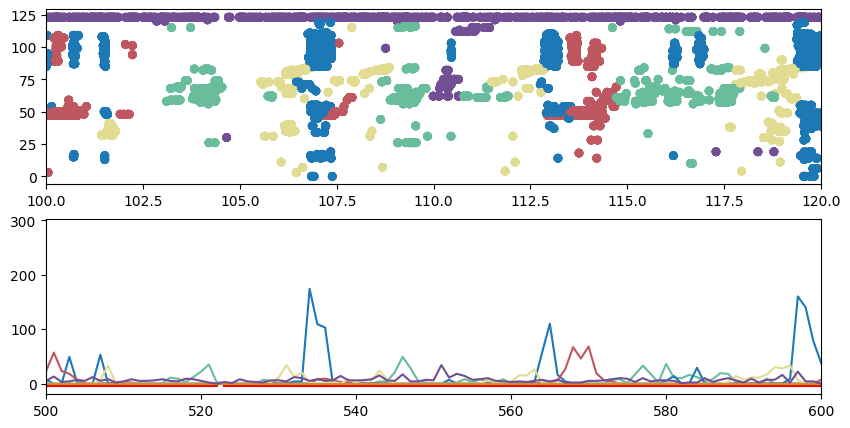

Optimization terminated successfully.
         Current function value: 0.384712
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     spindle_linage_binary   No. Observations:                 4246
Model:                             Logit   Df Residuals:                     4236
Method:                              MLE   Df Model:                            9
Date:                   Thu, 03 Jul 2025   Pseudo R-squ.:                 0.01570
Time:                           13:26:07   Log-Likelihood:                -1633.5
converged:                          True   LL-Null:                       -1659.5
Covariance Type:               nonrobust   LLR p-value:                 4.311e-08
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8857      0.086    -21.963      0.000      -2.

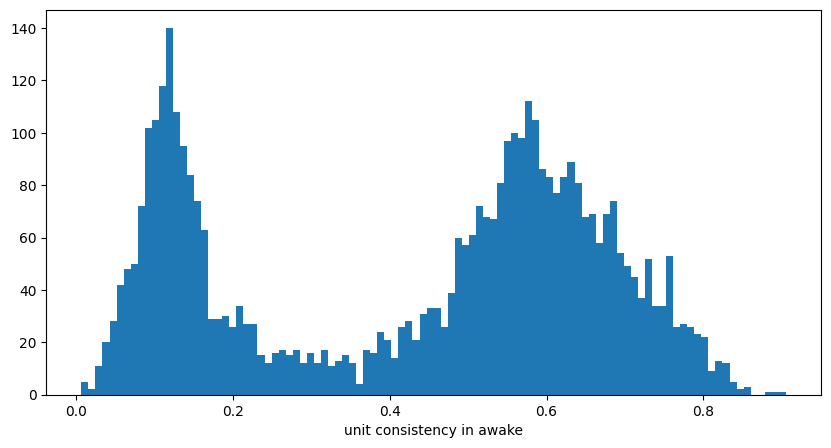

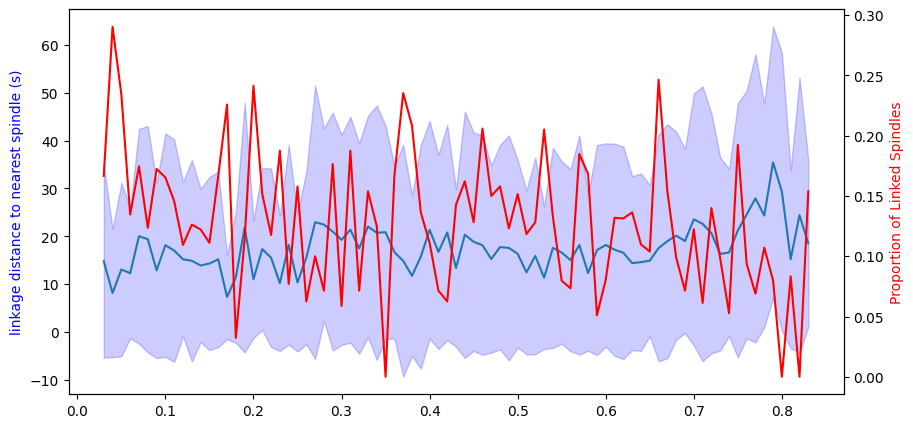

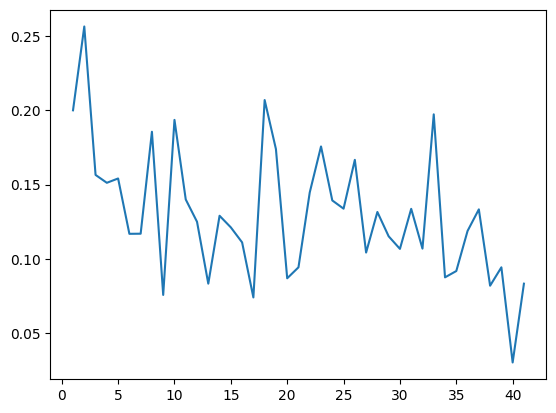

In [ ]:
plt.plot()

In [468]:
1/20

0.05

'136_1_3_run_2701023_1835'

In [132]:
awake_file_path

'Z:\\projects\\sequence_squad\\ppseq_finalised_publication_data\\\\expert/awake\\136_1_3_run_2701023_1835'

In [102]:
sleep_start_time

219.9999999999991

In [99]:
relative_time



4396.872458796802

In [81]:
other_

[]

In [76]:
sequence_order_df

,group,mir,dominant_task_seqs,other_task_seqs,seq_order,color_order_names,color_order_codes
0,expert,148_2_2,4.0,0.0,"[0, 3, 5, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
1,expert,136_1_3,4.0,0.0,"[2, 0, 3, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
2,expert,136_1_4,5.0,0.0,"[0, 2, 5, 4, 3]","['red', 'green', 'yellow', 'blue', 'purple']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5' '#724...
3,expert,149_1_1,4.0,0.0,"[5, 0, 4, 1]","['red', 'green', 'yellow', 'blue']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5']
4,expert,149_1_2,5.0,1.0,"[5, 0, 4, 3, 2]","['red', 'green', 'yellow', 'blue', 'purple']",['#BE575F' '#69BD9D' '#E2DC92' '#1C79B5' '#724...
...,...,...,...,...,...,...,...
58,learning,seq007_1_1,5.0,0.0,"[3, 2, 4, 5, 1]","['red', 'green', 'yellow', 'blue', 'purple']","['#BE575F', '#69BD9D', '#E2DC92', '#1C79B5', '..."
59,learning,seq007_1_2,4.0,1.0,"[4, 3, 1, 5, 0]","['red', 'green', 'yellow', 'blue', 'purple']","['#BE575F', '#69BD9D', '#E2DC92', '#1C79B5', '..."
60,learning,seq007_1_3,6.0,0.0,"[2, 3, 4, 0, 5, 1]","['red', 'green', 'yellow', 'blue', 'purple','g...","['#BE575F', '#69BD9D', '#E2DC92', '#1C79B5', '..."
61,expert,seq007_1_4,5.0,0.0,"[3, 4, 1, 0, 5]","['red', 'green', 'yellow', 'blue', 'purple']","['#BE575F', '#69BD9D', '#E2DC92', '#1C79B5', '..."


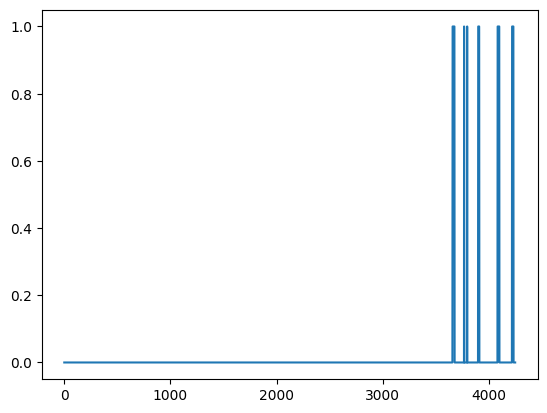

In [64]:
plt.plot(replay_events_df.rem_events)

In [55]:
coactive_partners

7

In [42]:
replay_events_df[1076:1080]

,Unnamed: 0,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,ordering_classification,rem_events,nrem_events,chunk,chunk_time,first_spike_ephys_time,replay_abs_time
1076,1076,6,19,0.1458,0.0378,0.1080,0.1458,"[0.0385, 0.0467, 0.0586, 0.0503, 0.0852, 0.087...","[29.0, 29.0, 29.0, 32.0, 42.0, 42.0, 42.0, 42....",[112. 112. 112. 114. 123. 123. 123. 123. 123. ...,0.0,sequential,0,0,1,"[8700, 9300]",0.0378,8700.09180
1077,1077,6,7,1.2057,1.1660,0.0397,1.2057,"[1.182, 1.1748, 1.1818, 1.1975, 1.2057, 1.166,...","[29.0, 95.0, 95.0, 95.0, 103.0, 107.0, 107.0]",[112. 113. 113. 113. 61. 82. 82.],620.0,fragmented,0,0,1,"[8700, 9300]",1.1660,8701.18585
1078,1078,6,7,6.7120,6.6082,0.1038,6.7120,"[6.6699, 6.712, 6.6363, 6.6082, 6.6559, 6.6599...","[88.0, 88.0, 98.0, 99.0, 100.0, 100.0, 100.0]",[116. 116. 58. 115. 64. 64. 64.],4.0,NaN,0,0,1,"[8700, 9300]",6.6082,8706.66010
1079,1079,6,16,14.8843,14.7711,0.1132,14.8843,"[14.8403, 14.844, 14.8415, 14.7711, 14.8394, 1...","[42.0, 42.0, 85.0, 95.0, 95.0, 96.0, 97.0, 97....",[123. 123. 120. 113. 113. 57. 74. 74. 58. ...,13.0,fragmented,0,0,1,"[8700, 9300]",14.7711,8714.82770


In [ ]:
## AUC

## vs shuffled data, maybe

In [ ]:

# 1. Separate target (y) and features (X)
y = logitical_dataframe['logistic_binned_replay']                # Dependent variable
X = logitical_dataframe.drop(columns=['logistic_binned_replay']) # Independent variables only

# 2. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)              # Scales all independent variables

# 3. Keep it in a DataFrame (optional but helpful for viewing column names)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


# Add constant (intercept)
X_const = sm.add_constant(X_scaled_df)

# Fit logistic regression model
logit_model = sm.Logit(y, X_const)
results = logit_model.fit()

# Print summary
print(results.summary())

# save out the results object 
import pickle
with open(output_path + 'logistic_regression_results_object.pkl', 'wb') as f:
    pickle.dump(results, f)
        

NameError: name 'logitical_dataframe' is not defined

In [2]:
logitical_dataframe

    

NameError: name 'logitical_dataframe' is not defined